In [1]:
#初始化模块 initial module
%matplotlib notebook
import torch
import math
import matplotlib.pyplot as plt
import torch.nn as nn
# import h5py
import numpy as np
from scipy import io
from mpl_toolkits.mplot3d import Axes3D
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from matplotlib.pyplot import MultipleLocator

torch.set_printoptions(precision=15)
print(torch.cuda.is_available())
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

False


In [2]:
### user's setting

dataFile = 'D:\\wechat-file\\WeChat-Files\\wxid_ywk5radgx1mi22\\FileStorage\\File\\workspace\\pyto\\项目1\\data\\pca14.mat'
mat = io.loadmat(dataFile)
datarec=mat['score']
datarec=torch.from_numpy(datarec).float();

rec=[0,3137,6271,9330,12641,15662]
recn=[]
for k in range(5):
    recn.append(rec[k+1]-rec[k])

print(datarec[0:1]);

dim=14;
longn=3000
learning_rate = 1e-3
segm=3
delta1=1/segm
lastloss=0;
ss=2
sstr=1
del2=1

tr_num_learn=0 # the trace need to be learnt

for k in range(5):
    name="data"+'%d' %k
    locals()[name]=datarec[rec[k]:rec[k+1],0:dim]
#     locals()[name]=locals()[name].to(dev)

reclen=torch.tensor([rec[i+1]-rec[i] for i in range(5)])

## compute the smooth data trace
scoe=0.3
for k in range(5):
    name="data"+'%d' %k
    locals()["ave"+name]=(scoe*locals()[name][0:reclen[k]-2]+\
                          locals()[name][1:reclen[k]-1]+\
                          scoe*locals()[name][2:reclen[k]])/(2*scoe+1)

## prepare for training
name="data"+'%d' %tr_num_learn
x_start=locals()[name][0:reclen[tr_num_learn]-ss-1]
x_target=torch.zeros(reclen[tr_num_learn]-ss-1,dim,ss)
for k in range(ss):
    x_target[:,:,k]= locals()["ave"+name][k:reclen[tr_num_learn]-ss-1+k]
train_ds = TensorDataset(x_start, x_target)
bt_size=150
datatr_loader = DataLoader(train_ds, batch_size=bt_size,shuffle=True)

loss_fn = torch.nn.MSELoss(reduction='sum')


tensor([[-0.404950469732285, -0.125637084245682,  0.290102809667587,
          0.176704913377762, -0.145935639739037,  0.068543523550034,
         -0.040213689208031, -0.000506849726662, -0.037676446139812,
         -0.123931199312210,  0.067150823771954,  0.015110116451979,
          0.020249528810382, -0.002167134778574]])


In [3]:
#载入数据的预备工作 loading data module

def loadcoe(names,iscuda):
    dataFile = '.\\data\\'+names+'.mat'#replace with your path of data
    locals()["mat"+names] = io.loadmat(dataFile)
    locals()[names]=locals()["mat"+names][names]/1.0
    locals()[names]=torch.from_numpy(locals()[names]).float();
    if iscuda:
        return(locals()[names].to(dev))
    else:
        return(locals()[names])
    
dataFile = '.\\data\\traa.mat'#replace with your path of data
mat1 = io.loadmat(dataFile)
traa=mat1['traA']
traa=torch.from_numpy(traa).float();

dataFile = '.\\data\\trab.mat'#replace with your path of data
mat1 = io.loadmat(dataFile)
trab=mat1['traB']
trab=torch.from_numpy(trab).float();

for (names,iscu) in [
    ('cc0',False),('state1',False),('state2',False),('state3',False),
    ('state4',False),('state5',False),("strec",True),("stnum",True),
    ("stcogo",True),("stconu",True),("stcoar",True),("starr",True),
    ("fpsarr",False),("stgosorted",True)]:
    locals()[names]=loadcoe(names,iscu)
    
fpsarr=fpsarr.squeeze(1)
nename=["AIBL","AIBR","ALA","AVAL","AVAR","AVBL","AVBR","AVER","RIBL","RID","RIML","RIMR","RIVL","RIVR"]

colorname=["red","orange","yellow","green","blue","blue","pink","grey"]
fps=2.904629629629630

statename=['Forward','Slow','Dorsal turn','Ventral turn',' Reverse',' Reverse','Sustained reverse','NOSTATE']
staten=["Forward","Slow","D turn","V turn","Reverse","Reverse","S reverse"]
leishu=[55,61,34,124,47,61,80,3];
cumleishu=torch.zeros(9)
cumleishu[0]=0
for k in range(8):
    cumleishu[k+1]=cumleishu[k]+leishu[k]

cumleishu=cumleishu.clone().type(torch.int)
state1=state1.clone().type(torch.int)
state1=state1[0]
print(state1)
print(state2)

tensor([2, 2, 2,  ..., 1, 1, 2], dtype=torch.int32)
tensor([[2., 2., 7.,  ..., 2., 2., 2.]])


In [ ]:
# 学习模块  #learning module
model = torch.nn.Sequential(
    torch.nn.Linear(dim, 120),
    torch.nn.ReLU(False),
    torch.nn.Linear(120, 120),
    torch.nn.ReLU(False),
    torch.nn.Linear(120,120),
    torch.nn.Sigmoid(),#
    torch.nn.Linear(120, dim),
#     torch.nn.Flatten(0, 10)
)
model.to(dev)

# optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer.zero_grad()



for epoch in range(200):
    for xpre,xtar in datatr_loader:
        xpre=xpre.to(dev)
        xtar=xtar.to(dev)
        for k in range(ss):
            for j in range(segm):
                xpre=xpre+(model(xpre)-xpre*del2)*delta1/fpsarr[tr_num_learn]
            if k<sstr:
                continue
            if k==sstr:
                loss = loss_fn(xpre,xtar[:,:,k])
            else:
                loss=loss+loss_fn(xpre,xtar[:,:,k])
        
    
#     if t % 200 == 199 and lastloss < loss and learning_rate > 1e-8:
#         learning_rate = learning_rate/1.4
#         optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
#         optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
#     if epoch % 100 == 99:
    print(epoch, loss.item(),learning_rate)
        
    if epoch% 50 ==49:
        lastloss=loss

    loss.backward()

    optimizer.step()

    optimizer.zero_grad()


In [63]:
learning_rate = learning_rate/10

In [64]:
# 补充学习模块 longer learning module
for epoch in range(6000):
    for xpre,xtar in datatr_loader:
        xpre=xpre.to(dev)
        xtar=xtar.to(dev)
        for k in range(ss):
            for j in range(segm):
                xpre=xpre+(model(xpre)-xpre*del2)*delta1/fpsarr[tr_num_learn]
            if k<sstr:
                continue
            if k==sstr:
                loss = loss_fn(xpre,xtar[:,:,k])
            else:
                loss=loss+loss_fn(xpre,xtar[:,:,k])
        
    
#     if t % 200 == 199 and lastloss < loss and learning_rate > 1e-8:
#         learning_rate = learning_rate/1.4
#         optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
#         optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
#     if epoch % 100 == 99:
    print(epoch, loss.item(),learning_rate)
        
    if epoch% 50 ==49:
        lastloss=loss

    loss.backward()

    optimizer.step()

    optimizer.zero_grad()

0 6.730800628662109 1e-05
1 6.449361801147461 1e-05
2 7.271384239196777 1e-05
3 6.584736347198486 1e-05
4 6.587709903717041 1e-05
5 6.731987953186035 1e-05
6 6.666667938232422 1e-05
7 6.543529510498047 1e-05
8 6.592129707336426 1e-05
9 6.6324896812438965 1e-05
10 6.427872180938721 1e-05
11 6.321596622467041 1e-05
12 6.685129165649414 1e-05
13 6.440808296203613 1e-05
14 5.972546100616455 1e-05
15 6.419996738433838 1e-05
16 6.2416791915893555 1e-05
17 5.962123870849609 1e-05
18 6.458492279052734 1e-05
19 5.777392387390137 1e-05
20 6.625633716583252 1e-05
21 5.892768859863281 1e-05
22 6.059514999389648 1e-05
23 5.908459186553955 1e-05
24 5.506537437438965 1e-05
25 5.856348991394043 1e-05
26 5.564112663269043 1e-05
27 6.024332046508789 1e-05
28 5.647339820861816 1e-05
29 5.691287040710449 1e-05
30 5.642115116119385 1e-05
31 5.235980033874512 1e-05
32 5.850417137145996 1e-05
33 5.950486183166504 1e-05
34 5.887833595275879 1e-05
35 5.620144844055176 1e-05
36 5.9777913093566895 1e-05
37 5.216

293 2.2346601486206055 1e-05
294 2.426875591278076 1e-05
295 2.113798141479492 1e-05
296 2.5209360122680664 1e-05
297 2.371398448944092 1e-05
298 2.3774118423461914 1e-05
299 2.0203027725219727 1e-05
300 2.3531312942504883 1e-05
301 2.121591567993164 1e-05
302 2.4815196990966797 1e-05
303 2.6715469360351562 1e-05
304 2.144160747528076 1e-05
305 2.0981435775756836 1e-05
306 1.9984886646270752 1e-05
307 2.2898073196411133 1e-05
308 2.100510597229004 1e-05
309 2.022653818130493 1e-05
310 1.9705138206481934 1e-05
311 2.2690746784210205 1e-05
312 1.9616658687591553 1e-05
313 2.290497064590454 1e-05
314 2.1697473526000977 1e-05
315 2.419109344482422 1e-05
316 2.0991668701171875 1e-05
317 2.122107982635498 1e-05
318 2.387636661529541 1e-05
319 2.3013503551483154 1e-05
320 2.1658883094787598 1e-05
321 2.0988550186157227 1e-05
322 1.9127578735351562 1e-05
323 1.902984857559204 1e-05
324 2.2633156776428223 1e-05
325 2.095329761505127 1e-05
326 2.0877959728240967 1e-05
327 2.291529655456543 1e-05

581 1.2688162326812744 1e-05
582 1.2899073362350464 1e-05
583 1.2537174224853516 1e-05
584 1.3012869358062744 1e-05
585 1.2236716747283936 1e-05
586 1.2475343942642212 1e-05
587 1.1402392387390137 1e-05
588 1.1961675882339478 1e-05
589 1.21466064453125 1e-05
590 1.2777241468429565 1e-05
591 1.000913143157959 1e-05
592 1.133594036102295 1e-05
593 1.2066794633865356 1e-05
594 1.1594822406768799 1e-05
595 1.3533639907836914 1e-05
596 1.2628681659698486 1e-05
597 1.3638464212417603 1e-05
598 1.3788321018218994 1e-05
599 1.2042279243469238 1e-05
600 1.1474902629852295 1e-05
601 1.195090651512146 1e-05
602 1.165310025215149 1e-05
603 1.365125298500061 1e-05
604 1.202402114868164 1e-05
605 1.1186378002166748 1e-05
606 1.1467969417572021 1e-05
607 1.2810251712799072 1e-05
608 1.3031834363937378 1e-05
609 1.1993072032928467 1e-05
610 0.9337102770805359 1e-05
611 1.2068144083023071 1e-05
612 1.147605061531067 1e-05
613 1.1659893989562988 1e-05
614 1.1989470720291138 1e-05
615 1.0824062824249268 

867 1.1118146181106567 1e-05
868 1.093055248260498 1e-05
869 1.0142444372177124 1e-05
870 1.0842187404632568 1e-05
871 1.0722293853759766 1e-05
872 1.1218606233596802 1e-05
873 0.9199725389480591 1e-05
874 0.9502015113830566 1e-05
875 1.05411696434021 1e-05
876 1.0165611505508423 1e-05
877 0.9786617159843445 1e-05
878 1.0300970077514648 1e-05
879 1.1609058380126953 1e-05
880 1.1637327671051025 1e-05
881 1.258448839187622 1e-05
882 0.9440946578979492 1e-05
883 1.137652039527893 1e-05
884 1.1251903772354126 1e-05
885 1.1417065858840942 1e-05
886 1.2179805040359497 1e-05
887 1.1049432754516602 1e-05
888 1.1467504501342773 1e-05
889 1.1648684740066528 1e-05
890 1.0402262210845947 1e-05
891 1.272352933883667 1e-05
892 1.1214299201965332 1e-05
893 1.0311062335968018 1e-05
894 1.083051323890686 1e-05
895 1.014528512954712 1e-05
896 1.0449146032333374 1e-05
897 0.9832748770713806 1e-05
898 1.1139395236968994 1e-05
899 0.9844905734062195 1e-05
900 1.1081044673919678 1e-05
901 1.0281109809875488

1148 0.8495898246765137 1e-05
1149 1.0376203060150146 1e-05
1150 0.8945193886756897 1e-05
1151 0.7865924835205078 1e-05
1152 0.8926914930343628 1e-05
1153 1.1079280376434326 1e-05
1154 0.8847126960754395 1e-05
1155 0.9405133724212646 1e-05
1156 0.9268026351928711 1e-05
1157 0.8934889435768127 1e-05
1158 1.0305235385894775 1e-05
1159 0.9561017155647278 1e-05
1160 1.0268131494522095 1e-05
1161 0.8089663982391357 1e-05
1162 1.2572355270385742 1e-05
1163 1.000915765762329 1e-05
1164 0.949365496635437 1e-05
1165 0.9465006589889526 1e-05
1166 1.0781142711639404 1e-05
1167 0.9750702381134033 1e-05
1168 0.9300358295440674 1e-05
1169 0.8656504154205322 1e-05
1170 0.8869905471801758 1e-05
1171 1.010352373123169 1e-05
1172 1.0191725492477417 1e-05
1173 0.9391279220581055 1e-05
1174 1.025144100189209 1e-05
1175 1.1409168243408203 1e-05
1176 0.8663808107376099 1e-05
1177 0.9209930300712585 1e-05
1178 1.054092526435852 1e-05
1179 1.0257675647735596 1e-05
1180 0.8522175550460815 1e-05
1181 0.85422730

1423 0.8820894956588745 1e-05
1424 0.9072520732879639 1e-05
1425 0.8934416770935059 1e-05
1426 1.0446386337280273 1e-05
1427 0.8144415020942688 1e-05
1428 0.9539890289306641 1e-05
1429 0.7341374158859253 1e-05
1430 0.9879258275032043 1e-05
1431 0.9046118259429932 1e-05
1432 0.8064973950386047 1e-05
1433 0.8699976205825806 1e-05
1434 0.7934805750846863 1e-05
1435 0.9165266752243042 1e-05
1436 0.871472954750061 1e-05
1437 1.0308809280395508 1e-05
1438 0.8268750309944153 1e-05
1439 1.0602850914001465 1e-05
1440 0.8515971899032593 1e-05
1441 0.7436951398849487 1e-05
1442 0.9567787647247314 1e-05
1443 1.0409111976623535 1e-05
1444 0.8286451101303101 1e-05
1445 0.8394134044647217 1e-05
1446 0.8222006559371948 1e-05
1447 0.8776663541793823 1e-05
1448 0.8353254199028015 1e-05
1449 0.8952646255493164 1e-05
1450 0.8435124158859253 1e-05
1451 0.9214870929718018 1e-05
1452 0.8137601613998413 1e-05
1453 0.7284063696861267 1e-05
1454 0.9277549386024475 1e-05
1455 0.8110858798027039 1e-05
1456 0.8476

1697 0.832550585269928 1e-05
1698 0.8197312951087952 1e-05
1699 0.7249813675880432 1e-05
1700 0.8101270198822021 1e-05
1701 0.7546775341033936 1e-05
1702 0.817768931388855 1e-05
1703 0.6842968463897705 1e-05
1704 0.7328944206237793 1e-05
1705 0.8709787130355835 1e-05
1706 0.7864621877670288 1e-05
1707 0.7397848963737488 1e-05
1708 0.8299914598464966 1e-05
1709 0.7337606549263 1e-05
1710 0.8691244125366211 1e-05
1711 0.8523284196853638 1e-05
1712 0.7830515503883362 1e-05
1713 0.6983895301818848 1e-05
1714 0.7459454536437988 1e-05
1715 0.6790928840637207 1e-05
1716 0.6566438674926758 1e-05
1717 0.8118195533752441 1e-05
1718 0.7714284658432007 1e-05
1719 0.7156534194946289 1e-05
1720 0.8225932121276855 1e-05
1721 0.7553702592849731 1e-05
1722 0.7278882265090942 1e-05
1723 0.7272111177444458 1e-05
1724 0.7856586575508118 1e-05
1725 0.8145244121551514 1e-05
1726 0.7995961904525757 1e-05
1727 0.7327468395233154 1e-05
1728 0.7495853304862976 1e-05
1729 0.8289076685905457 1e-05
1730 0.74556624

1973 0.6770234107971191 1e-05
1974 0.7014974355697632 1e-05
1975 0.6516265869140625 1e-05
1976 0.6730998754501343 1e-05
1977 0.6642910242080688 1e-05
1978 0.6754385232925415 1e-05
1979 0.5997945666313171 1e-05
1980 0.6374884247779846 1e-05
1981 0.623504638671875 1e-05
1982 0.6494455337524414 1e-05
1983 0.6622670888900757 1e-05
1984 0.772411048412323 1e-05
1985 0.7348239421844482 1e-05
1986 0.6924005746841431 1e-05
1987 0.6578978300094604 1e-05
1988 0.5865459442138672 1e-05
1989 0.679738461971283 1e-05
1990 0.703931450843811 1e-05
1991 0.594176173210144 1e-05
1992 0.6588096618652344 1e-05
1993 0.5252524614334106 1e-05
1994 0.7540709972381592 1e-05
1995 0.6947664022445679 1e-05
1996 0.6614722609519958 1e-05
1997 0.6476777195930481 1e-05
1998 0.5873615741729736 1e-05
1999 0.6926271319389343 1e-05
2000 0.6039442420005798 1e-05
2001 0.7162030935287476 1e-05
2002 0.6696735620498657 1e-05
2003 0.6270140409469604 1e-05
2004 0.663129448890686 1e-05
2005 0.6612745523452759 1e-05
2006 0.676501631

2248 0.6821191310882568 1e-05
2249 0.5963224172592163 1e-05
2250 0.5828157663345337 1e-05
2251 0.668013334274292 1e-05
2252 0.6273866891860962 1e-05
2253 0.6590704321861267 1e-05
2254 0.5374463796615601 1e-05
2255 0.7416516542434692 1e-05
2256 0.5748370885848999 1e-05
2257 0.7820406556129456 1e-05
2258 0.6590818762779236 1e-05
2259 0.5039994716644287 1e-05
2260 0.6973177194595337 1e-05
2261 0.7465601563453674 1e-05
2262 0.6910791397094727 1e-05
2263 0.6444153189659119 1e-05
2264 0.6957775354385376 1e-05
2265 0.6563868522644043 1e-05
2266 0.5548232793807983 1e-05
2267 0.6542844772338867 1e-05
2268 0.4825354218482971 1e-05
2269 0.593276858329773 1e-05
2270 0.5243253707885742 1e-05
2271 0.44618430733680725 1e-05
2272 0.5512428879737854 1e-05
2273 0.667289137840271 1e-05
2274 0.6065242290496826 1e-05
2275 0.5602372884750366 1e-05
2276 0.6866781711578369 1e-05
2277 0.6508111953735352 1e-05
2278 0.587799072265625 1e-05
2279 0.5818603038787842 1e-05
2280 0.6030116081237793 1e-05
2281 0.605593

2524 0.5736806392669678 1e-05
2525 0.6654074192047119 1e-05
2526 0.687136173248291 1e-05
2527 0.5965061187744141 1e-05
2528 0.7936367988586426 1e-05
2529 0.6366488933563232 1e-05
2530 0.6505160927772522 1e-05
2531 0.5642286539077759 1e-05
2532 0.599721372127533 1e-05
2533 0.6758883595466614 1e-05
2534 0.5094990730285645 1e-05
2535 0.5546131134033203 1e-05
2536 0.6041184663772583 1e-05
2537 0.6548527479171753 1e-05
2538 0.6589357852935791 1e-05
2539 0.6892518997192383 1e-05
2540 0.6555368304252625 1e-05
2541 0.5092251300811768 1e-05
2542 0.4994657337665558 1e-05
2543 0.5912712812423706 1e-05
2544 0.5581779479980469 1e-05
2545 0.5098856091499329 1e-05
2546 0.5270386934280396 1e-05
2547 0.555858850479126 1e-05
2548 0.5998376607894897 1e-05
2549 0.5627878904342651 1e-05
2550 0.5783595442771912 1e-05
2551 0.5641747713088989 1e-05
2552 0.5531715154647827 1e-05
2553 0.6024205684661865 1e-05
2554 0.5992333889007568 1e-05
2555 0.5730347633361816 1e-05
2556 0.5521613359451294 1e-05
2557 0.552090

2799 0.5355883240699768 1e-05
2800 0.53639817237854 1e-05
2801 0.5921348333358765 1e-05
2802 0.5199835896492004 1e-05
2803 0.5260128378868103 1e-05
2804 0.5544297695159912 1e-05
2805 0.572231113910675 1e-05
2806 0.5474241971969604 1e-05
2807 0.6326971054077148 1e-05
2808 0.7120181322097778 1e-05
2809 0.5859147310256958 1e-05
2810 0.5504699945449829 1e-05
2811 0.6072795391082764 1e-05
2812 0.5422776937484741 1e-05
2813 0.5593522787094116 1e-05
2814 0.5711405277252197 1e-05
2815 0.5473805665969849 1e-05
2816 0.5430419445037842 1e-05
2817 0.6422597169876099 1e-05
2818 0.5446231365203857 1e-05
2819 0.5678912997245789 1e-05
2820 0.6420634984970093 1e-05
2821 0.5163812637329102 1e-05
2822 0.5035663843154907 1e-05
2823 0.5437549352645874 1e-05
2824 0.5745961666107178 1e-05
2825 0.5246602296829224 1e-05
2826 0.5888494253158569 1e-05
2827 0.5423712730407715 1e-05
2828 0.6076092720031738 1e-05
2829 0.5750217437744141 1e-05
2830 0.5453633666038513 1e-05
2831 0.5667975544929504 1e-05
2832 0.573853

3073 0.5826481580734253 1e-05
3074 0.6247400045394897 1e-05
3075 0.6082202196121216 1e-05
3076 0.5563930869102478 1e-05
3077 0.5427869558334351 1e-05
3078 0.5693255066871643 1e-05
3079 0.5668684244155884 1e-05
3080 0.5539391040802002 1e-05
3081 0.5478762984275818 1e-05
3082 0.6596569418907166 1e-05
3083 0.5856202840805054 1e-05
3084 0.575595498085022 1e-05
3085 0.5150641798973083 1e-05
3086 0.5566206574440002 1e-05
3087 0.5787050724029541 1e-05
3088 0.5319405794143677 1e-05
3089 0.6439276933670044 1e-05
3090 0.527175784111023 1e-05
3091 0.467389315366745 1e-05
3092 0.5157318115234375 1e-05
3093 0.5664529800415039 1e-05
3094 0.5987919569015503 1e-05
3095 0.5540639162063599 1e-05
3096 0.6169905066490173 1e-05
3097 0.5546776056289673 1e-05
3098 0.5814333558082581 1e-05
3099 0.5711585283279419 1e-05
3100 0.5507977604866028 1e-05
3101 0.46206676959991455 1e-05
3102 0.5845381021499634 1e-05
3103 0.5444543361663818 1e-05
3104 0.5655512809753418 1e-05
3105 0.5753552913665771 1e-05
3106 0.53661

3347 0.5452579259872437 1e-05
3348 0.3958079516887665 1e-05
3349 0.540534496307373 1e-05
3350 0.4873718023300171 1e-05
3351 0.5904059410095215 1e-05
3352 0.4740808308124542 1e-05
3353 0.4756701588630676 1e-05
3354 0.5182493925094604 1e-05
3355 0.5123835802078247 1e-05
3356 0.5690308809280396 1e-05
3357 0.4969678521156311 1e-05
3358 0.5716288089752197 1e-05
3359 0.5863144397735596 1e-05
3360 0.5508065819740295 1e-05
3361 0.5289217233657837 1e-05
3362 0.515498161315918 1e-05
3363 0.49170419573783875 1e-05
3364 0.6789569854736328 1e-05
3365 0.5735113024711609 1e-05
3366 0.4926772117614746 1e-05
3367 0.4923362135887146 1e-05
3368 0.5204998254776001 1e-05
3369 0.49766838550567627 1e-05
3370 0.5641437768936157 1e-05
3371 0.5040757060050964 1e-05
3372 0.49015504121780396 1e-05
3373 0.48740044236183167 1e-05
3374 0.48339471220970154 1e-05
3375 0.6424070596694946 1e-05
3376 0.5507780313491821 1e-05
3377 0.4423750340938568 1e-05
3378 0.5407533645629883 1e-05
3379 0.5399662256240845 1e-05
3380 0.

3622 0.5212423801422119 1e-05
3623 0.5841035842895508 1e-05
3624 0.51292884349823 1e-05
3625 0.48884323239326477 1e-05
3626 0.4880628287792206 1e-05
3627 0.49534493684768677 1e-05
3628 0.5152955651283264 1e-05
3629 0.6473451256752014 1e-05
3630 0.49599575996398926 1e-05
3631 0.467637836933136 1e-05
3632 0.5148900747299194 1e-05
3633 0.5112735629081726 1e-05
3634 0.5095500349998474 1e-05
3635 0.5362149477005005 1e-05
3636 0.6290903091430664 1e-05
3637 0.580327033996582 1e-05
3638 0.4371076226234436 1e-05
3639 0.5983303785324097 1e-05
3640 0.6143641471862793 1e-05
3641 0.6020429134368896 1e-05
3642 0.5285712480545044 1e-05
3643 0.6467550992965698 1e-05
3644 0.49171289801597595 1e-05
3645 0.6617600917816162 1e-05
3646 0.5123779773712158 1e-05
3647 0.5004754066467285 1e-05
3648 0.448581337928772 1e-05
3649 0.49102461338043213 1e-05
3650 0.575626015663147 1e-05
3651 0.5495848655700684 1e-05
3652 0.5492015480995178 1e-05
3653 0.50164395570755 1e-05
3654 0.5209723711013794 1e-05
3655 0.599495

3895 0.5445511937141418 1e-05
3896 0.43860432505607605 1e-05
3897 0.46487173438072205 1e-05
3898 0.5484299659729004 1e-05
3899 0.547806978225708 1e-05
3900 0.4892878830432892 1e-05
3901 0.5331645607948303 1e-05
3902 0.4492383301258087 1e-05
3903 0.5577508211135864 1e-05
3904 0.49443718791007996 1e-05
3905 0.49917805194854736 1e-05
3906 0.5015926361083984 1e-05
3907 0.4804476797580719 1e-05
3908 0.521741509437561 1e-05
3909 0.5280980467796326 1e-05
3910 0.5462632179260254 1e-05
3911 0.5115092396736145 1e-05
3912 0.5102288722991943 1e-05
3913 0.50580894947052 1e-05
3914 0.4515729546546936 1e-05
3915 0.49421966075897217 1e-05
3916 0.5070074796676636 1e-05
3917 0.5521564483642578 1e-05
3918 0.48197051882743835 1e-05
3919 0.47796040773391724 1e-05
3920 0.4925466477870941 1e-05
3921 0.5013973116874695 1e-05
3922 0.502475380897522 1e-05
3923 0.4476633369922638 1e-05
3924 0.5286482572555542 1e-05
3925 0.5289748907089233 1e-05
3926 0.5377643704414368 1e-05
3927 0.5563915967941284 1e-05
3928 0.4

4167 0.4583824872970581 1e-05
4168 0.5326141715049744 1e-05
4169 0.5006623864173889 1e-05
4170 0.49719616770744324 1e-05
4171 0.5160924792289734 1e-05
4172 0.568345844745636 1e-05
4173 0.4512415826320648 1e-05
4174 0.46397948265075684 1e-05
4175 0.5826855897903442 1e-05
4176 0.5139703750610352 1e-05
4177 0.5668103694915771 1e-05
4178 0.4854969084262848 1e-05
4179 0.4681962728500366 1e-05
4180 0.5164333581924438 1e-05
4181 0.49103623628616333 1e-05
4182 0.48636534810066223 1e-05
4183 0.4702507257461548 1e-05
4184 0.46502235531806946 1e-05
4185 0.4720953404903412 1e-05
4186 0.4593326449394226 1e-05
4187 0.5580019950866699 1e-05
4188 0.4406927824020386 1e-05
4189 0.4835219085216522 1e-05
4190 0.46971216797828674 1e-05
4191 0.49388235807418823 1e-05
4192 0.5062854290008545 1e-05
4193 0.5723443627357483 1e-05
4194 0.5312599539756775 1e-05
4195 0.47351503372192383 1e-05
4196 0.5150434970855713 1e-05
4197 0.5275777578353882 1e-05
4198 0.4589731693267822 1e-05
4199 0.4896652102470398 1e-05
420

4440 0.4964252710342407 1e-05
4441 0.46684059500694275 1e-05
4442 0.48751726746559143 1e-05
4443 0.5111457705497742 1e-05
4444 0.4731585383415222 1e-05
4445 0.4177275002002716 1e-05
4446 0.5979160070419312 1e-05
4447 0.4652075171470642 1e-05
4448 0.470583975315094 1e-05
4449 0.48817723989486694 1e-05
4450 0.48902320861816406 1e-05
4451 0.45995286107063293 1e-05
4452 0.47813814878463745 1e-05
4453 0.5496121644973755 1e-05
4454 0.4203890562057495 1e-05
4455 0.5379002094268799 1e-05
4456 0.5457538366317749 1e-05
4457 0.5160678625106812 1e-05
4458 0.5015541315078735 1e-05
4459 0.48653343319892883 1e-05
4460 0.5049762725830078 1e-05
4461 0.45028653740882874 1e-05
4462 0.4814012944698334 1e-05
4463 0.5240657329559326 1e-05
4464 0.539095401763916 1e-05
4465 0.49822258949279785 1e-05
4466 0.47670236229896545 1e-05
4467 0.4222111105918884 1e-05
4468 0.5118812322616577 1e-05
4469 0.5467325448989868 1e-05
4470 0.47462230920791626 1e-05
4471 0.5010402202606201 1e-05
4472 0.45323383808135986 1e-05


4712 0.4319295585155487 1e-05
4713 0.5645200610160828 1e-05
4714 0.4295384883880615 1e-05
4715 0.4656081199645996 1e-05
4716 0.41545578837394714 1e-05
4717 0.45115381479263306 1e-05
4718 0.5133305191993713 1e-05
4719 0.4124283194541931 1e-05
4720 0.42684704065322876 1e-05
4721 0.5095163583755493 1e-05
4722 0.49461519718170166 1e-05
4723 0.43161195516586304 1e-05
4724 0.5042837858200073 1e-05
4725 0.5162144899368286 1e-05
4726 0.5319275856018066 1e-05
4727 0.4435913562774658 1e-05
4728 0.5072505474090576 1e-05
4729 0.45814192295074463 1e-05
4730 0.48347344994544983 1e-05
4731 0.4243791997432709 1e-05
4732 0.4205591082572937 1e-05
4733 0.47407323122024536 1e-05
4734 0.48426946997642517 1e-05
4735 0.42697852849960327 1e-05
4736 0.48534417152404785 1e-05
4737 0.4676923155784607 1e-05
4738 0.4599186182022095 1e-05
4739 0.40570133924484253 1e-05
4740 0.43372219800949097 1e-05
4741 0.5368114709854126 1e-05
4742 0.43483126163482666 1e-05
4743 0.454012930393219 1e-05
4744 0.4695854187011719 1e-

4984 0.46325141191482544 1e-05
4985 0.4108343720436096 1e-05
4986 0.5083370208740234 1e-05
4987 0.4342605471611023 1e-05
4988 0.4910220205783844 1e-05
4989 0.48738375306129456 1e-05
4990 0.4069965183734894 1e-05
4991 0.4011947512626648 1e-05
4992 0.47558683156967163 1e-05
4993 0.481631875038147 1e-05
4994 0.47036212682724 1e-05
4995 0.5158756971359253 1e-05
4996 0.49358105659484863 1e-05
4997 0.4312359690666199 1e-05
4998 0.4725407063961029 1e-05
4999 0.5271745920181274 1e-05
5000 0.42971599102020264 1e-05
5001 0.46725761890411377 1e-05
5002 0.43834686279296875 1e-05
5003 0.4978644847869873 1e-05
5004 0.44480353593826294 1e-05
5005 0.45169299840927124 1e-05
5006 0.49273747205734253 1e-05
5007 0.49854740500450134 1e-05
5008 0.5055993795394897 1e-05
5009 0.45006150007247925 1e-05
5010 0.4878992438316345 1e-05
5011 0.5237292051315308 1e-05
5012 0.5282015204429626 1e-05
5013 0.524152398109436 1e-05
5014 0.41008636355400085 1e-05
5015 0.5145750045776367 1e-05
5016 0.5047330856323242 1e-05
5

5255 0.4157103896141052 1e-05
5256 0.4461633265018463 1e-05
5257 0.44684094190597534 1e-05
5258 0.5097107291221619 1e-05
5259 0.45243075489997864 1e-05
5260 0.4116317927837372 1e-05
5261 0.4644228219985962 1e-05
5262 0.41127151250839233 1e-05
5263 0.4436036944389343 1e-05
5264 0.5040994882583618 1e-05
5265 0.488704651594162 1e-05
5266 0.5273431539535522 1e-05
5267 0.4348556399345398 1e-05
5268 0.440886914730072 1e-05
5269 0.4592422544956207 1e-05
5270 0.47011804580688477 1e-05
5271 0.4432903230190277 1e-05
5272 0.4535646438598633 1e-05
5273 0.46406257152557373 1e-05
5274 0.444890558719635 1e-05
5275 0.3990456759929657 1e-05
5276 0.47779276967048645 1e-05
5277 0.41655203700065613 1e-05
5278 0.45827239751815796 1e-05
5279 0.541541337966919 1e-05
5280 0.4723743200302124 1e-05
5281 0.4236356019973755 1e-05
5282 0.43711137771606445 1e-05
5283 0.5352892875671387 1e-05
5284 0.46194761991500854 1e-05
5285 0.5175677537918091 1e-05
5286 0.43306615948677063 1e-05
5287 0.4240480065345764 1e-05
528

KeyboardInterrupt: 

In [20]:
# state10=state1.clone().type(torch.long).unsqueeze(0)
# print(data1.shape)
# data_x=torch.cat((data0,data1,data2,data3,data4))
# print(state10.shape,state2.shape)
# data_st=torch.cat((state10,state2,state3,state4,state5),dim=1).squeeze()
# print(data_x.shape)
# print(data_st.shape)

torch.Size([3134, 14])
torch.Size([1, 3137]) torch.Size([1, 3134])
torch.Size([15662, 14])
torch.Size([15662])


In [24]:
# 状态模型  state learning module
learning_rate2 = 1e-2
# ind_left= state1!=8
# data0_left=data0[ind_left]
# state1_left=state1[ind_left]
ind_left= data_st!=8
data0_left=data_x[ind_left]
state1_left=data_st[ind_left]
train_ds = TensorDataset(data0_left, state1_left.clone().type(torch.long)-1)
bt_size=15662
datatr_loader = DataLoader(train_ds, batch_size=bt_size,shuffle=True)
criterion = nn.CrossEntropyLoss()

model2 = torch.nn.Sequential(
    torch.nn.Linear(dim, 120),
    torch.nn.ReLU(False),
    torch.nn.Linear(120, 120),
    torch.nn.ReLU(False),
    torch.nn.Linear(120,120),
    torch.nn.Sigmoid(),#
    torch.nn.Linear(120, 8),
#     torch.nn.Flatten(0, 10)
)
model2.to(dev)

# optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate2)
optimizer.zero_grad()



for epoch in range(500):
    for xpre,xst in datatr_loader:
        xpre=xpre.to(dev)
        xst=xst.to(dev)
        output = model2(xpre)
        loss=criterion(output,xst)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    if epoch% 10 == 1:
        print(loss)

learning_rate2 = 1e-3        
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate2)
optimizer.zero_grad()        
for epoch in range(500):
    for xpre,xst in datatr_loader:
        xpre=xpre.to(dev)
        xst=xst.to(dev)
        output = model2(xpre)
        loss=criterion(output,xst)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    if epoch% 10 == 1:
        print(loss)
        pred = output.argmax(1)
        print((pred==xst).sum()/bt_size)

tensor(1.877651691436768, grad_fn=<NllLossBackward0>)
tensor(1.085060238838196, grad_fn=<NllLossBackward0>)
tensor(0.839517056941986, grad_fn=<NllLossBackward0>)
tensor(0.747980475425720, grad_fn=<NllLossBackward0>)
tensor(0.690502643585205, grad_fn=<NllLossBackward0>)
tensor(0.647411882877350, grad_fn=<NllLossBackward0>)
tensor(0.616794884204865, grad_fn=<NllLossBackward0>)
tensor(0.589443683624268, grad_fn=<NllLossBackward0>)
tensor(0.563373208045959, grad_fn=<NllLossBackward0>)
tensor(0.537583470344543, grad_fn=<NllLossBackward0>)
tensor(0.506492972373962, grad_fn=<NllLossBackward0>)
tensor(0.474807441234589, grad_fn=<NllLossBackward0>)
tensor(0.442317903041840, grad_fn=<NllLossBackward0>)
tensor(0.428650617599487, grad_fn=<NllLossBackward0>)
tensor(0.398377627134323, grad_fn=<NllLossBackward0>)
tensor(0.404371589422226, grad_fn=<NllLossBackward0>)
tensor(0.371953994035721, grad_fn=<NllLossBackward0>)
tensor(0.351486146450043, grad_fn=<NllLossBackward0>)
tensor(0.339784860610962, gr

In [4]:
#载入已学好的模型 loding model module
model=torch.load('./mod/mod.pth').to(dev)
model2=torch.load("./mod/modelstate2.pth") 
# model=torch.load('./mod/re/modqig_seg2st1ss2verynice.pth')
# model=torch.load('./mod/re/modqig_seg1st0ss1canimproveandsee4and18and19nice.pth')
# print(model)

In [5]:
# curve fit setting module
simnu=60
seej=0
simj=0
seealltype=False
simtype=False
if seealltype:
    jra=simnu
else:
    jra=1
if simtype:
    kra=simnu
else:
    kra=1
delta2=0.05/segm

In [6]:
#模拟曲线模块 curve fitting module
# 2a1:0
# 2a2:1e-3
my_raodong=0
dis_ne=0
for j in range(kra):
    if not simtype:
        j=simj
    name1="data"+'%d' %j
    x1=torch.zeros(simnu,dim)
    
    for i in range(simnu):
#         if i<5:
#             continue
#         i=2
        start=50*i
        x1[i,:]=locals()[name1][start]
    x1=x1.to(dev)
    k=0
    name="xxa"+"s"+'%d' %j
    locals()["w1"+name]=torch.zeros(100000,simnu,dim).to(dev)
    stopsig=0
    with torch.no_grad():
        for t in range(36000):
            x1=x1+(model(x1)-x1*del2)*delta2
            if t%segm==segm-1:
                rd=torch.randn(simnu,dim)*(0)
                rd=rd.to(dev)
                x1=x1+rd
#                 x1=x1+torch.randn(dim)*(3e-3)
                locals()["w1"+name][k,:,:]=x1.detach()
                k=k+1
                if t%1000==999:
                    print(t)
    locals()["w1"+name+"cp"]=locals()["w1"+name].to(torch.device("cpu"))
            

2999
5999
8999
11999
14999
17999
20999
23999
26999
29999
32999
35999


In [24]:
#模拟曲线模块 with special start: curve fitting module with special start
my_raodong=0
dis_ne=0
simnu=15
simj=2
for j in range(1):
    j=2
    name1="data"+'%d' %j
    x1=torch.zeros(simnu,dim)
    spe_ind=[344,379,413,461,522,566,633,687,721,768,821,924,977,1031,1090]
    for i in range(15):
        x1[i,:]=locals()[name1][spe_ind[i]]
    x1=x1.to(dev)
    k=0
    name="xxa"+"s"+'%d' %j
    locals()["w1"+name]=torch.zeros(100000,simnu,dim).to(dev)
    stopsig=0
    with torch.no_grad():
        for t in range(36000):
            x1=x1+(model(x1)-x1*del2)*delta2
            if t%segm==segm-1:
                rd=torch.randn(simnu,dim)*(3e-4)
                rd=rd.to(dev)
                x1=x1+rd
#                 x1=x1+torch.randn(dim)*(3e-3)
                locals()["w1"+name][k,:,:]=x1.detach()
                k=k+1
                if t%1000==999:
                    print(t)
    locals()["w1"+name+"cp"]=locals()["w1"+name].to(torch.device("cpu"))
            

2999
5999
8999
11999
14999
17999
20999
23999
26999
29999
32999
35999


In [14]:
#模拟曲线模块,扰动 恒定扰动 :curve fitting module with constant inhibition
simnu=30
dis_ne=13
dis_coe=0.1
j=0
name1="data"+'%d' %j
x1=torch.zeros(simnu,dim)
for i in range(simnu):
    start=50*i
    x1[i,:]=locals()[name1][start]
x1=x1.to(dev)
k=0
name="xxa"+"s"+'%d' %j
locals()["w1"+name]=torch.zeros(40000,simnu,dim).to(dev)
stopsig=0
with torch.no_grad():
    dis_e=torch.zeros(dim,1)
    dis_e[dis_ne]=1
    dis_coe1=cc0@dis_e
    dis_coe1=dis_coe1.item()
    dis_tr=traa@dis_e
    dis_tr2=dis_e.T@trab
    dis_e=dis_e.to(dev)
    dis_tr=dis_tr.to(dev)
    dis_tr2=dis_tr2.to(dev)
    dis_coe2=dis_tr.T@dis_tr
    dis_coe2=dis_coe2.item()
    for t in range(36000):
        x1=x1+(model(x1)-x1*del2-10*(x1@dis_tr+dis_coe1)*dis_tr2*dis_coe)*delta2 
        if t%segm==segm-1:
            rd=torch.randn(dim)*(6e-4)
            rd=rd.to(dev)
            x1=x1+rd
            locals()["w1"+name][k,:,:]=x1.detach()
            k=k+1
            if t%1000==999:
                print(t)
locals()["w1"+name+"cp"]=locals()["w1"+name].to(torch.device("cpu"))
            
            
#         locals()["w1"+name][k-1,0]=1
#         locals()["w2"+name][k-1,0]=1
#         locals()["w3"+name][k-1,0]=1


2999
5999
8999
11999
14999
17999
20999
23999
26999
29999
32999
35999


In [67]:
#模拟曲线模块, 同轨一条线不同位置扰动 curve fitting module for one curve with constant inhibition staring in diffrent place
simnu=16
raodong_seg=500
raodong_start=2000
dis_ne=13
dis_coe=1
j=0
name1="data"+'%d' %j
x1=torch.zeros(simnu,dim)
for i in range(simnu):
    start=100
    x1[i,:]=locals()[name1][start]
x1=x1.to(dev)
k=0
name="xxa"+"s"+'%d' %j
locals()["w1"+name]=torch.zeros(40000,simnu,dim).to(dev)
stopsig=0
with torch.no_grad():
    dis_e=torch.zeros(dim,1)
    dis_e[dis_ne]=1
    dis_coe1=cc0@dis_e
    dis_coe1=dis_coe1.item()
    dis_tr=traa@dis_e
    dis_tr2=dis_e.T@trab
    dis_e=dis_e.to(dev)
    dis_tr=dis_tr.to(dev)
    dis_tr2=dis_tr2.to(dev)
    dis_coe2=dis_tr.T@dis_tr
    dis_coe2=dis_coe2.item()
    for t in range(36000):
        x1=x1+(model(x1)-x1*del2)*delta2 
        if t%segm==segm-1:
            rd=torch.randn(dim)*(3e-4)
            rd=rd.to(dev)
            x1=x1+rd
        sep_i=math.floor(min(max((t/segm-raodong_start)/raodong_seg,-0.5),simnu-2))
        x1[sep_i+2:simnu,:]=x1[0,:].repeat(simnu-2-sep_i,1)
        x1[1:sep_i+2,:]=x1[1:sep_i+2,:]-delta2*10*(x1[1:sep_i+2,:]@dis_tr+dis_coe1)*dis_tr2
        if t%segm==segm-1:
            locals()["w1"+name][k,:,:]=x1.detach()
            k=k+1
            if t%1000==999:
                print(sep_i)
                print(t)
locals()["w1"+name+"cp"]=locals()["w1"+name].to(torch.device("cpu"))
            
            
#         locals()["w1"+name][k-1,0]=1
#         locals()["w2"+name][k-1,0]=1
#         locals()["w3"+name][k-1,0]=1


-1
2999
-1
5999
1
8999
3
11999
5
14999
7
17999
9
20999
11
23999
13
26999
14
29999
14
32999
14
35999


In [41]:
# 载入轨迹模块 load trace module
# simnu=15
# name="xxa"+"s"+'%d' %j
# locals()["w1"+name]=torch.zeros(100000,simnu,dim).to(dev)
# for j in range(1):
#     for i in range(simnu):
# #         if i<15:
# #             continue
#         name="xxa"+"s"+'%d' %j
#         temptr=torch.load("./tr/tr6"+'%d' %i+".pth")
#         sizm,sizn=temptr.shape
#         locals()["w1"+name][0:sizm,i,:]=temptr

# simnu=15
# j=2
# simj=2
# name="xxa"+"s"+'%d' %j
# locals()["w1"+name]=torch.load("./tr/cyc2/1/tr_see=1nice_simnu=15.pth").to(dev)

# simnu=60
# j=0
# simj=0
# name="xxa"+"s"+'%d' %j
# locals()["w1"+name]=torch.load("./lastout/1-trace/cycle1-tr_see=3nice_simnu=60.pth").to(dev)


# locals()["w1"+name+"cp"]=locals()["w1"+name].to(torch.device("cpu"))
# j=1
# name="xxa"+"s"+'%d' %j
# locals()["w1"+name]=torch.load("./lastout/1-trace/tr_see=1nice_simnu=15.pth").to(dev)


# （winl=200 winr=11400）
# simnu=15
# j=0
# simj=0
# name="xxa"+"s"+'%d' %j
# locals()["w1"+name]=torch.load("./lastout/1-trace/tr_see=1nice_simnu=15.pth").to(dev)

# simnu=60
# j=0
# simj=0
# name="xxa"+"s"+'%d' %j
# locals()["w1"+name]=torch.load("./lastout/2-trace/tr_see=567nice_simnu=60.pth").to(dev)

# simnu=60
# j=0
# simj=0
# name="xxa"+"s"+'%d' %j
# locals()["w1"+name]=torch.load("./lastout/3-trace/trbignoise_see=0_simnu=60.pth").to(dev)

# simnu=16
# j=0
# simj=0
# name="xxa"+"s"+'%d' %j
# locals()["w1"+name]=torch.load("./lastout/8-ban13/trban13_see=3and5_simnu=16.pth").to(dev)

# j=0
# name="xxa"+"s"+'%d' %j
# locals()["w1"+name]=torch.load("./tr/rewrite/1/tr.pth").to(dev)
# locals()["w1"+name+"cp"]=locals()["w1"+name].to(torch.device("cpu"))

In [8]:
# cycle2_start=w1xxas0[200,1,:]
# print(cycle2_start)

In [9]:
# dataFile = 'C:\\Users\\zrszl\\Desktop\\pyto\\项目1\\data\\surface_B.mat'
# mat1 = io.loadmat(dataFile)
# surface_B=mat1['surface_B']
# xsidel=-0.8;xsider=0.9;ysidel=-0.6;ysider=0.4;step=0.005;
# xx=xsidel
# part_x=torch.ones(3)
# x1=torch.zeros(340,200,dim)
# for k in range(340):
#     yy=ysidel
#     for l in range(200):
#         part_x[1]=xx
#         part_x[2]=yy
#         x1[k,l,0]=xx
#         x1[k,l,1]=yy
#         x1[k,l,2:14]=(part_x@surface_B).T
#         yy=yy+step
#     xx=xx+step
# x1=x1.to(dev)
# Fx=model(x1)-x1*del2


In [10]:
# savex1=np.array(x1.detach().to(torch.device("cpu")))
# io.savemat("./lastout/5/x1.mat",{"x1":savex1}) 
# savefx=np.array(Fx.detach().to(torch.device("cpu")))
# io.savemat("./lastout/5/fx.mat",{"fx":savefx}) 

In [11]:
# j=0
# name="xxa"+"s"+'%d' %j 
# tem_x=torch.zeros(dim)
# parFij=torch.zeros(12000,dim,dim)
# Fi=torch.zeros(12000,dim)
# for i in range(12000):
#     tem_x=locals()["w1"+name+"cp"][i,1,:].to(dev)
#     tem_x.requires_grad=True
#     for j in range(dim):
#         if j>0:
#             tem_x.grad.zero_()
#         tem_y=model(tem_x)-del2*tem_x
#         Fi[i,:]=tem_y
#         y1jsum=torch.sum(tem_y[j])
#         y1jsum.backward()
#         parFij[i,j,:]=tem_x.grad
#     if i%1000==0:
#         print(i)
# save_parFij=np.array(parFij.detach().to(torch.device("cpu")))
# io.savemat("./lastout/6/parFij2.mat",{"parFij2":save_parFij})
# save_Fi=np.array(Fi.detach().to(torch.device("cpu")))
# io.savemat("./lastout/6/Fi2.mat",{"Fi2":save_Fi})

In [7]:
#画图辅助函数
# the prepare function for ploting

def my_plot3(tr,left,right,colorname="null",dim1=0,dim2=1,dim3=2):
    if colorname=="null":
        line,=ax.plot3D(tr[left:right,dim1].squeeze(-1),tr[left:right,dim2].squeeze(-1),tr[left:right,dim3].squeeze(-1))
    else:
        line,=ax.plot3D(tr[left:right,dim1].squeeze(-1),tr[left:right,dim2].squeeze(-1),tr[left:right,dim3].squeeze(-1),color=colorname)
    return line

def my_plot3_w_st(tr,left,right,state):
    statelas1=state[left];
    lasswi=0
    for k in range(right):
        if k<left:
            continue
        if state[k+1]!=statelas1:
            my_plot3(tr,lasswi,k+2,colorname[statelas1.clone().type(torch.int).item()-1])
            lasswi=k+1
            statelas1=state[k+1]
    my_plot3(tr,lasswi,k+2,colorname[statelas1.clone().type(torch.int).item()-1])

def my_sca3(tr,left,right,colorname="null"):
    if colorname=="null":
        line=ax.scatter(tr[left:right,0].squeeze(-1),tr[left:right,1].squeeze(-1),tr[left:right,2].squeeze(-1))
    else:
        line=ax.scatter(tr[left:right,0].squeeze(-1),tr[left:right,1].squeeze(-1),tr[left:right,2].squeeze(-1),color=colorname)
    return line



def my_plot(tr,left,right,colorname="null",dim1=0,dim2=1):
    if colorname=="null":
        line,=plt.plot(tr[left:right,dim1].squeeze(-1),tr[left:right,dim2].squeeze(-1))
    else:
        line,=plt.plot(tr[left:right,dim1].squeeze(-1),tr[left:right,dim2].squeeze(-1),color=colorname)
    return line

def my_plot_w_st(tr,left,right,state,dim1=0,dim2=1):
    statelas1=state[left];
    lasswi=0
    for k in range(right):
        if k<left:
            continue
        if state[k+1]!=statelas1:
            my_plot(tr,lasswi,k+2,colorname[statelas1.clone().type(torch.int).item()-1],dim1,dim2)
            lasswi=k+1
            statelas1=state[k+1]
    my_plot(tr,lasswi,k+2,colorname[statelas1.clone().type(torch.int).item()-1],dim1,dim2)

def my_sca(tr,left,right,colorname="null",dim1=0,dim2=1):
    if colorname=="null":
        line=plt.scatter(tr[left:right,dim1].squeeze(-1),tr[left:right,dim2].squeeze(-1))
    else:
        line=plt.scatter(tr[left:right,dim1].squeeze(-1),tr[left:right,dim2].squeeze(-1),color=colorname)
    return line


def plot_data(PC=True,ne1=0,ne2=1):
    for j in range(jra):
        if not seealltype:
            j=seej
        if PC:
            names="data%dcp" %j
        else:
            names="datasol%d" %j
        line=my_plot(globals()[names],0,recn[j],"gray",ne1,ne2)
        if not seealltype:
            break
    return line

plotarray=[0,1,4,5,6,2,3]

<IPython.core.display.Javascript object>


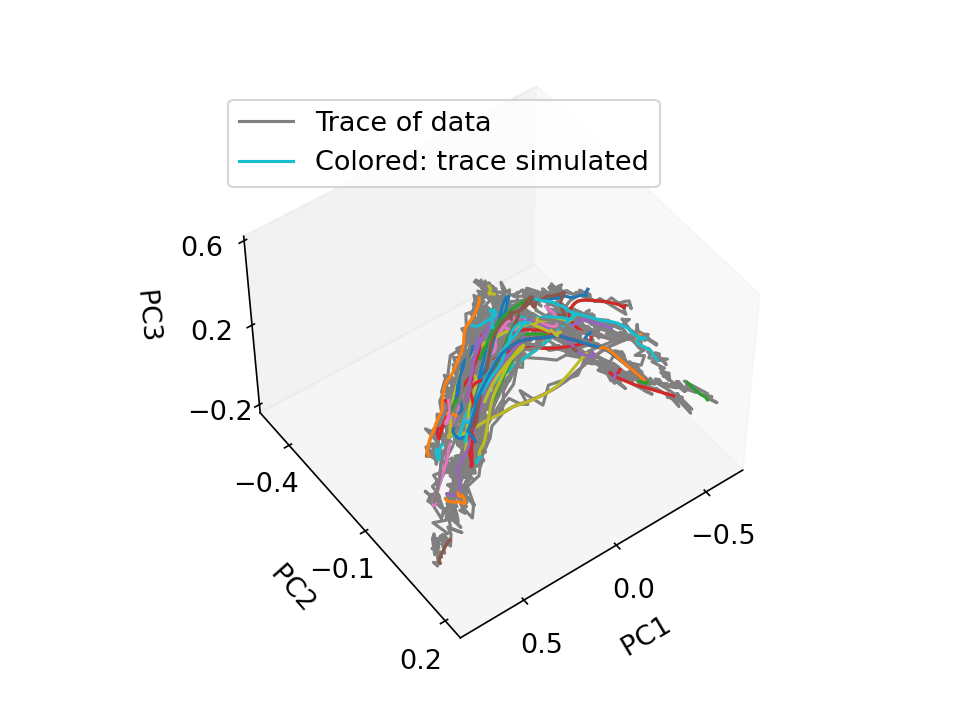

60


In [8]:
#3维主成分画图
# plot trace in 3D

fig = plt.figure(4)
ax = plt.axes(projection='3d')
ax.view_init(48.863636363637,53.73376623376663)
# ax.view_init(90,-90)
for j in range(jra):
    if not seealltype:
        j=seej
    tempj=j+1
    names="state"+"%d" %tempj
    state=locals()[names]
    names="data%d" %j
    locals()[names+"cp"]=locals()[names].to(torch.device("cpu"))
    line1=my_plot3(locals()[names+"cp"],0,recn[j],"gray")
#     line1=my_plot3_w_st(locals()[names+"cp"],0,recn[j]-1,state)
    
see=-1
winl=0
winr=12000
print(simnu)
for j in range(kra): 
    if not simtype:
        j=simj
    for i in range(simnu):
        if see >= 0:
            i=see
        name="xxa"+"s"+'%d' %j 
        line2=my_plot3(locals()["w1"+name+"cp"][:,i,:],winl,winr)        
#         line2,=my_plot3(locals()["w1"+name+"cp"][:,i,:],winl,my_raodong-1,"null")
#         line2,=my_plot3(locals()["w1"+name+"cp"][:,i,:],my_raodong-1,winr,"null")
#         line3=my_sca3(locals()["w1"+name+"cp"][:,i,:],my_raodong-1,my_raodong,"red")
        if see >= 0:
            break;
plt.legend([line1,line2],["Trace of data","Colored: trace simulated"],loc="upper left",fontsize=13)
ax.grid(False)

ax.tick_params(labelsize=13)
ax.set_xlabel("\nPC1 ",fontsize=13) 
ax.set_ylabel("\nPC2 ",fontsize=13) 
ax.set_zlabel("\nPC3 ",fontsize=13) 
# ax.xaxis.set_minor_locator(MultipleLocator(1))
# ax.yaxis.set_minor_locator(MultipleLocator(1))
# ax.zaxis.set_minor_locator(MultipleLocator(1))
ax.set_xticks([-0.5, 0, 0.5])
ax.set_yticks([-0.4, -0.1, 0.2])
ax.set_zticks([-0.2,0.2,0.6])
# savefig_path="./lastout/out-ori/2a1"
# plt.savefig(savefig_path+".pdf",dpi=500)
# plt.savefig(savefig_path+".tif",dpi=500)

# plt.figure(5)

# plt.plot(kcou[0:1000],xxb2[0:1000])
# plt.plot(kcou[0:1000],xxb1[0:1000])¶

In [34]:
# print(ax.elev,ax.azim) 

# plt.savefig("./pic/show5/aa.png",dpi=500)

48.863636363637 53.73376623376663


In [47]:
# torch.save(locals()["w1"+name+"cp"],"./disa_tr/4/tr1i2raodong9500.pth")

In [48]:
# locals()["w1"+name+"cp"]=torch.load("./disa_tr/13/tr1i2raodong8500.pth")
# my_raodong=8500

In [9]:
###### 2维多种展示准备
# the prepare function for ploting 2D

shwtyp=False    ## false兼容老式，true兼容新式

kcou=torch.zeros(500000,5)
kcou1=torch.zeros(500000,5)

tfie=12000

movet=torch.zeros(5,1);
move=0;

if not shwtyp:
    trant=10
    movet[0]=move/fps/10
else:
    trant=delta1/delta2
    for j in range(5):
        movet[j]=move/fpsarr[j]*(delta2/delta1)

        
winl=0
winr=12000
# 8:1,4
#7 see =1,3,4,
# 6:see=18
# 3:see=2 move=500/580
#4:see=3 move=?
# 5 :see=7/8 nomove

for j in range(5):
    kcou[:,j]=torch.tensor(range(500000))
    kcou1[:,j]=torch.tensor(range(500000))
    
if not shwtyp:
    for j in range(5):
        kcou[:,j]=(kcou[:,j]+move)/fpsarr[j]/10
else:
    for j in range(5):
        kcou[:,j]=(kcou[:,j]+move)/fpsarr[j]*(delta2/delta1)

for j in range(5):
    kcou1[:,j]=(kcou1[:,j]+move)/fpsarr[j] 

<IPython.core.display.Javascript object>


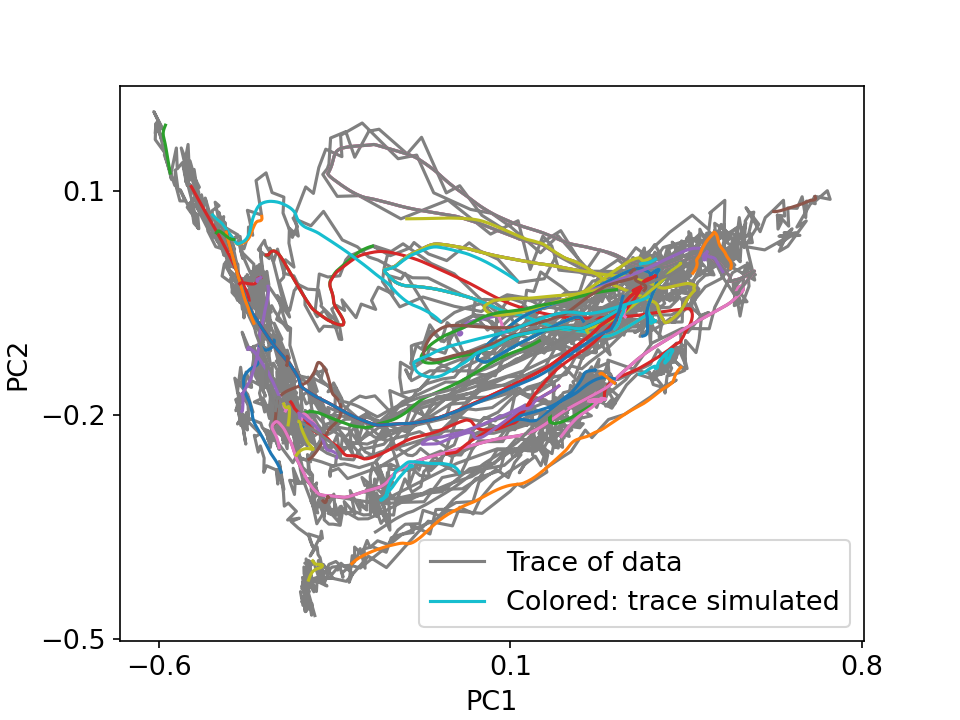

<IPython.core.display.Javascript object>


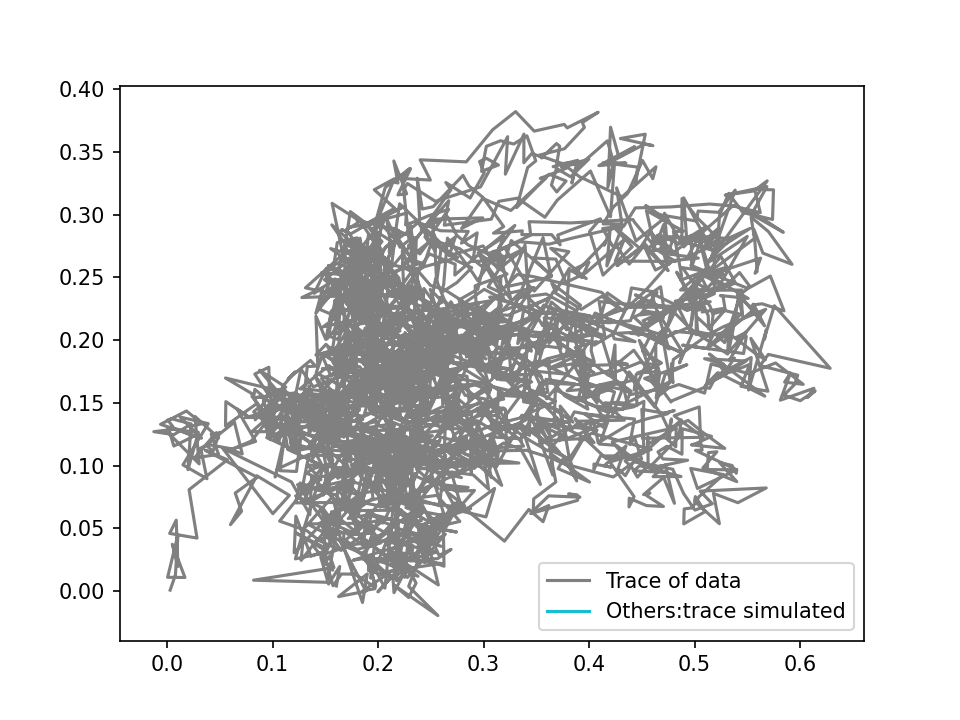

In [10]:
#2维画图
# plot trace in 2D
see=-2
move=0
is_raodong=False;
ne1=7
ne2=2
# ne1=3# ne2=9# ne1=3# ne2=4# ne1=11# ne2=9# ne1=9# ne2=11# ne1=9# ne2=12# ne1=4# ne2=11# ne1=4# ne2=11# ne1=9# ne2=8# ne1=0# ne2=13
nes=4

winl=0 
winr=12000 #f8

for j in range(kra):
    plt.figure(5+100*j)
#     plt_sca=plt.scatter(locals()["w1"+name+"cp"][200,1,0],locals()["w1"+name+"cp"][200,1,1],s=100,color='green')    
#     plt_sca.set_zorder(11)
    if see!=-1 and see!=-3:
        line1=plot_data(True,0,1);
    plt.xlabel("PC1",fontsize=13)
    plt.ylabel("PC2",fontsize=13)
    if not simtype:
        j=simj
    for i in range(simnu):
        if see>=0:
            i=see
            name="xxa"+"s"+'%d' %j
            if is_raodong:
                line2=my_plot(locals()["w1"+name+"cp"][:,i,:],winl,my_raodong-1,"green")
                line3=my_plot(locals()["w1"+name+"cp"][:,i,:],my_raodong-1,winr,"red")
                line4=my_plot(locals()["w1"+name+"cp"][:,i,:],my_raodong-1,my_raodong,"black")
                line4.set_zorder(2)
                plt.legend([line1,line2,line3,line4],["data","simulation before disabling","simulation after disabling","point of disabling"])
            else:
                line2=my_plot(locals()["w1"+name+"cp"][:,i,:],winl,winr,"red",0,1)
                plt.legend([line1,line2],["trace of data","trace simulated"])
            break        
#         if i < 30:
#             continue
        if see==-1:
            plt.figure(50+i+100*j)
            line1=plot_data();
        plt.xlabel("PC1",fontsize=13)
        plt.ylabel("PC2",fontsize=13)
        name="xxa"+"s"+'%d' %j
        if is_raodong:
            line2=my_plot(locals()["w1"+name+"cp"][:,i,:],winl,my_raodong-1,"green")
            line3=my_plot(locals()["w1"+name+"cp"][:,i,:],my_raodong-1,winr,"red")
            line4=my_sca(locals()["w1"+name+"cp"][:,i,:],my_raodong-1,my_raodong,"black")
            line4.set_zorder(2)
            plt.legend([line1,line2,line3,line4],["data","simulation before disabling","simulation after disabling","point of disabling"])
        else:
            if see<-1:
                line2=my_plot(locals()["w1"+name+"cp"][:,i,:],winl,winr)
            else:
                line2=my_plot(locals()["w1"+name+"cp"][:,i,:],winl,winr,"red")
#             line2=my_plot(locals()["w1"+name+"cp"][:,i,:],winl,winr)
            #plt.legend([line1,line2],["trace of data","trace simulated"])
            #plt.legend([line1,line2],["trace of data","others:trace simulated"],fontsize=12)

#forpic8  
# if see==-2:
#     line2=my_plot(locals()["w1"+name+"cp"][:,0,:],winl,winr)
#     line2=my_plot(locals()["w1"+name+"cp"][:,0,:],winl,winr)
#     line2=my_plot(locals()["w1"+name+"cp"][:,0,:],winl,winr)
#     plt.legend([line1,line2],["trace of data","others:trace simulated"],fontsize=12)
#for pic8 pic2d
ax=plt.gca()
ax.set_xticks([-0.6, 0.1, 0.8])# f8c 2d
ax.set_yticks([-0.5, -0.2, 0.1])# f8c 2d

# next
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.title("each color means a trace we simulated\n and the point means the end of the trace")
plt.legend([line1,line2],["Trace of data","Colored: trace simulated"],fontsize=13)

# plt.savefig("./lastout/5/1.pdf",dpi=500)
# plt.savefig("./lastout/5/dis13coe0.1sim3.jpg",dpi=500)
# plt.savefig("./lastout/out3/8/d.pdf",dpi=500)
# plt.savefig("./lastout/out3/8/d.tif",dpi=500)
# plt.savefig("./lastout/out4/2e.pdf",dpi=500)
# plt.savefig("./lastout/out4/2e.tif",dpi=500)
# plt.savefig("./lastout/out-ori/8c.pdf",dpi=500)
# plt.savefig("./lastout/out-ori/8c.tif",dpi=500)
# plt.savefig("./lastout/out-ori/2d.pdf",dpi=500)
# plt.savefig("./lastout/out-ori/2d.tif",dpi=500)

for j in range(jra):
    if not seealltype:
        j=seej
    names="%d" %j
    locals()["datasol"+names]=locals()["data"+names+"cp"]@traa+cc0
for j in range(jra):
    plt.figure(6+100*j)
    if not seealltype:
        j=seej
    names="datasol%d" %j
    line1=plot_data(False,ne1,ne2)
    if not simtype:
        j=simj
    if see>=0:
        i=see
        name="xxa"+"s"+'%d' %j
        locals()["wso"+name]=locals()["w1"+name+"cp"]@traa+cc0
        line2,=plt.plot(locals()["wso"+name][winl:winr,i,ne1].squeeze(-1),locals()["wso"+name][winl:winr,i,ne2].squeeze(-1),"red")
        if is_raodong:
            line2=my_plot(locals()["wso"+name][:,i,:],winl,my_raodong-1,"green",ne1,ne2)
            line3=my_plot(locals()["wso"+name][:,i,:],my_raodong-1,winr,"red",ne1,ne2)
            line4=my_sca(locals()["wso"+name][:,i,:],my_raodong-1,my_raodong,"black",ne1,ne2)
            line4.set_zorder(2)
            plt.legend([line1,line2,line3,line4],["data","simulation before disabling","simulation after disabling","point of disabling"])
        else:
            line2=my_plot(locals()["wso"+name][:,i,:],winl,winr,"red",ne1,ne2)
            plt.legend([line1,line2],["trace of data","trace simulated"])
        plt.xlabel(nename[ne1]+" activity")
        plt.ylabel(nename[ne2]+" activity")        
# plt.legend([line1,line2],["trace of data","and others: trace simulated using the learned F"])
plt.legend([line1,line2],["Trace of data","Others:trace simulated"])
# # plt.savefig("./show1/23.png")




# plt.figure(7)
# for j in range(jra):
#     if not seealltype:
#         j=seej
#     names="datasol%d" %j
#     line1,=plt.plot(kcou1[0:round(tfie/trant),0],locals()[names][i*50:i*50+round(tfie/trant),nes],color="gray")
# for j in range(kra):
#     if not simtype:
#         j=simj
#     for i in range(1):
#         i=see
#         name="xxa"+"s"+'%d' %j
#         locals()["wso"+name]=locals()["w1"+name+"cp"]@traa+cc0
#         line2,=plt.plot(kcou[winl:winr,j],locals()["wso"+name][winl:winr,i,nes].squeeze(-1),"red")
# #         line3=plt.scatter(kcou[500,j],locals()["wso"+name][500,i,nes].squeeze(-1),color="black")
# #         line3.set_zorder(2)
# plt.xlabel("time(s)")
# plt.ylabel(nename[nes]+" activity")
# # plt.legend([line1,line2],["data","and others:simulated using the learned F"])
# plt.legend([line1,line2],["trace of data","trace simulated,moved \n through t axes "+'%.2f' %movet[0] + "s"])
# # plt.legend([line1,line2],["trace of data","t1race simulated"])

# plt.savefig("./lastout/out4/2e.pdf",dpi=500)
# plt.savefig("./lastout/out4/8/2e.tif",dpi=500)



#3,18

torch.Size([40000, 16, 14])

In [66]:
# j=0
# name="xxa"+"s"+'%d' %j
# savecycle=np.array(locals()["w1"+name][0:12000,3,:])
# io.savemat("./lastout/out3/dis13/cycle2coe0.2.mat",{"cycle2":savecycle})            

In [62]:
#模拟曲线模块,扰动 恒定扰动
# # 0.02 0.04 0.08 0.1 0.2 0.3
# simnu=4
# dis_ne=13
# dis_coe=0.2
# j=0
# name1="data"+'%d' %j
# x1=torch.zeros(simnu,dim)
# # x1[2,:]=locals()[name1][100]
# x1[0,:]=torch.tensor([ 0.383432328701019, -0.008770209737122,  0.278092473745346,
#         -0.007047316525131,  0.064723089337349,  0.128932848572731,
#         -0.127335116267204,  0.010444960556924, -0.037215020507574,
#          0.046392936259508,  0.061080697923899, -0.007886825129390,
#         -0.037233985960484, -0.009063987992704])
# x1[1,:]=torch.tensor([ 0.288135141134262, -0.180263921618462,  0.017334828153253,
#          0.047641739249229, -0.026285089552402,  0.323385268449783,
#         -0.141068905591965, -0.054988633841276, -0.042012408375740,
#         -0.039858110249043, -0.032674267888069,  0.054257974028587,
#          0.015232254751027,  0.091671794652939])
# x1[2,:]=torch.tensor([-0.237985864281654, -0.186475738883018,  0.245175063610077,
#          0.042261317372322, -0.040564838796854, -0.061944551765919,
#          0.028784090653062,  0.036500189453363, -0.077814325690269,
#          0.021959986537695,  0.106747731566429,  0.039640273898840,
#          0.034177582710981,  0.002072973409668])
# x1[3,:]=torch.tensor([ 0.243470922112465, -0.069240204989910,  0.313836425542831,
#         -0.014558319933712, -0.009469780139625,  0.254133909940720,
#         -0.146125972270966, -0.046156998723745, -0.151451423764229,
#         -0.037389539182186,  0.017728855833411,  0.048510517925024,
#         -0.019225675612688,  0.020837994292378])
# x1=x1.to(dev)
# k=0
# name="xxa"+"s"+'%d' %j
# locals()["w1"+name]=torch.zeros(40000,simnu,dim).to(dev)
# stopsig=0
# with torch.no_grad():
#     dis_e=torch.zeros(dim,1)
#     dis_e[dis_ne]=1
#     dis_coe1=cc0@dis_e
#     dis_coe1=dis_coe1.item()
#     dis_tr=traa@dis_e
#     dis_tr2=dis_e.T@trab
#     dis_e=dis_e.to(dev)
#     dis_tr=dis_tr.to(dev)
#     dis_tr2=dis_tr2.to(dev)
#     dis_coe2=dis_tr.T@dis_tr
#     dis_coe2=dis_coe2.item()
#     for t in range(36000):
#         x1=x1+(model(x1)-x1*del2-2*(x1@dis_tr+dis_coe1)*dis_tr2*dis_coe)*delta2 
#         if t%segm==segm-1:
#             rd=torch.randn(dim)*(6e-4)
#             rd=rd.to(dev)
#             x1=x1+rd
#             locals()["w1"+name][k,:,:]=x1.detach()
#             k=k+1
#             if t%1000==999:
#                 print(t)
# locals()["w1"+name+"cp"]=locals()["w1"+name].to(torch.device("cpu"))
            
            
#         locals()["w1"+name][k-1,0]=1
#         locals()["w2"+name][k-1,0]=1
#         locals()["w3"+name][k-1,0]=1


2999
5999
8999
11999
14999
17999
20999
23999
26999
29999
32999
35999


3


In [157]:
# print(cycle2_start)
# j=0
# name1="data"+'%d' %j
# print(locals()[name1][150])
# print(start2)
# print(start3)

tensor([ 0.383432328701019, -0.008770209737122,  0.278092473745346,
        -0.007047316525131,  0.064723089337349,  0.128932848572731,
        -0.127335116267204,  0.010444960556924, -0.037215020507574,
         0.046392936259508,  0.061080697923899, -0.007886825129390,
        -0.037233985960484, -0.009063987992704])
tensor([ 0.288135141134262, -0.180263921618462,  0.017334828153253,
         0.047641739249229, -0.026285089552402,  0.323385268449783,
        -0.141068905591965, -0.054988633841276, -0.042012408375740,
        -0.039858110249043, -0.032674267888069,  0.054257974028587,
         0.015232254751027,  0.091671794652939])
tensor([-0.237985864281654, -0.186475738883018,  0.245175063610077,
         0.042261317372322, -0.040564838796854, -0.061944551765919,
         0.028784090653062,  0.036500189453363, -0.077814325690269,
         0.021959986537695,  0.106747731566429,  0.039640273898840,
         0.034177582710981,  0.002072973409668])
tensor([ 0.243470922112465, -0.069240

In [94]:
# j=0
# name="xxa"+"s"+'%d' %j
# savetr=np.array(locals()["w1"+name+"cp"][0:12000,2,:])
# io.savemat("./raod/old1/tra13.mat",{"tra":savetr})     

<IPython.core.display.Javascript object>


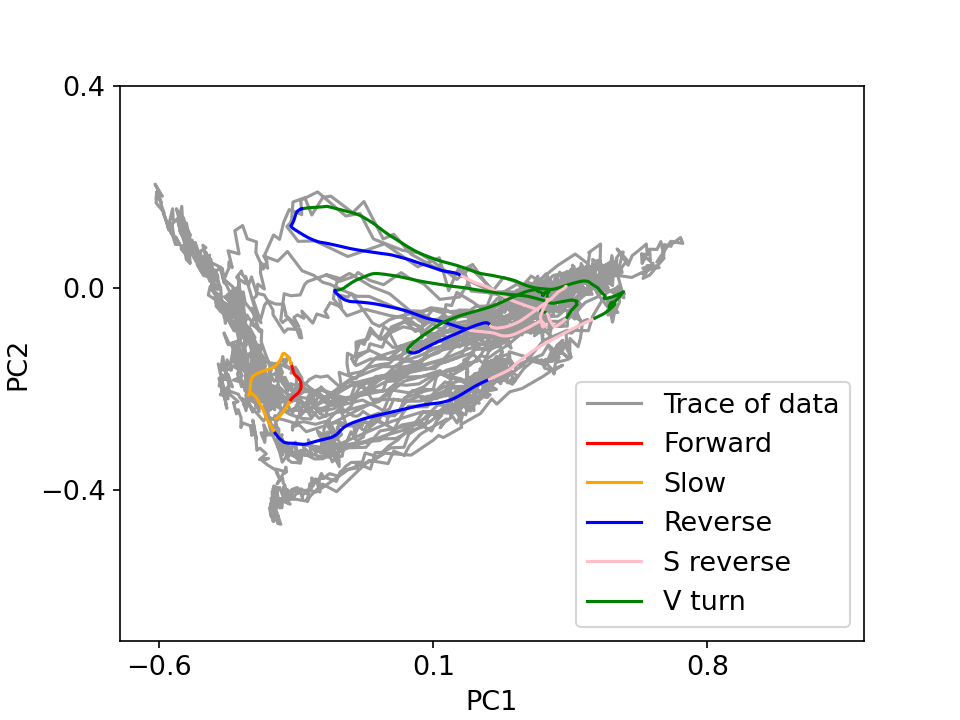

tensor([1.])


<IPython.core.display.Javascript object>


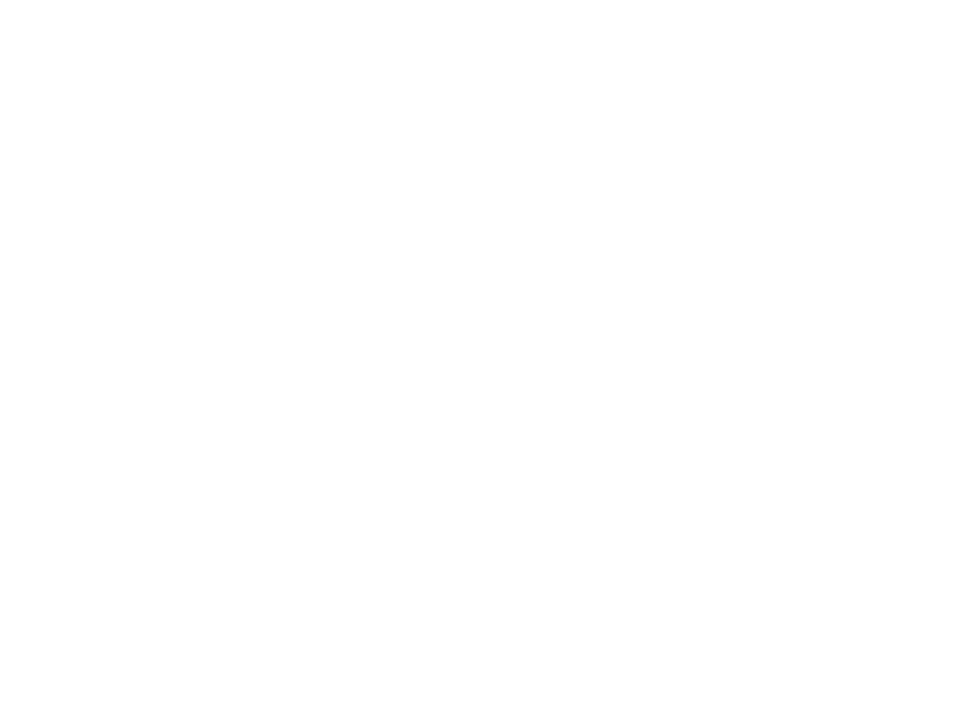

<IPython.core.display.Javascript object>


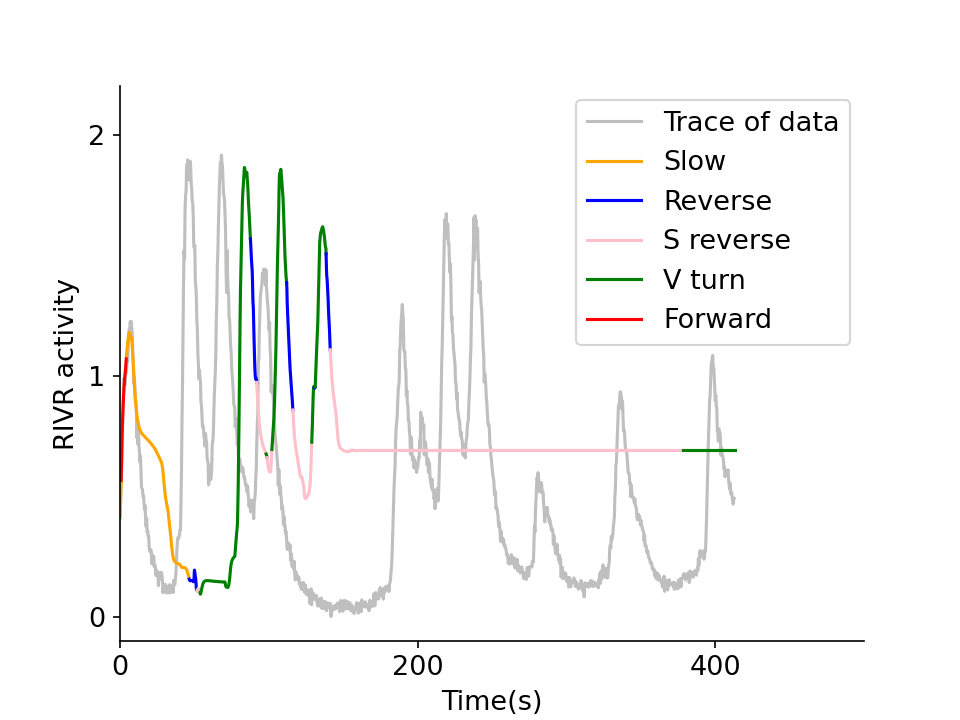

tensor([0.000000000000000e+00, 3.442779928445816e-02, 6.885559856891632e-02,
         ..., 1.721379492187500e+04, 1.721383007812500e+04,
        1.721386328125000e+04])
tensor([0.000000000000000e+00, 3.442779779434204e-01, 6.885559558868408e-01,
         ..., 1.721379531250000e+05, 1.721382968750000e+05,
        1.721386406250000e+05])
[1, 0, 5, 6, 3, 4]


<IPython.core.display.Javascript object>


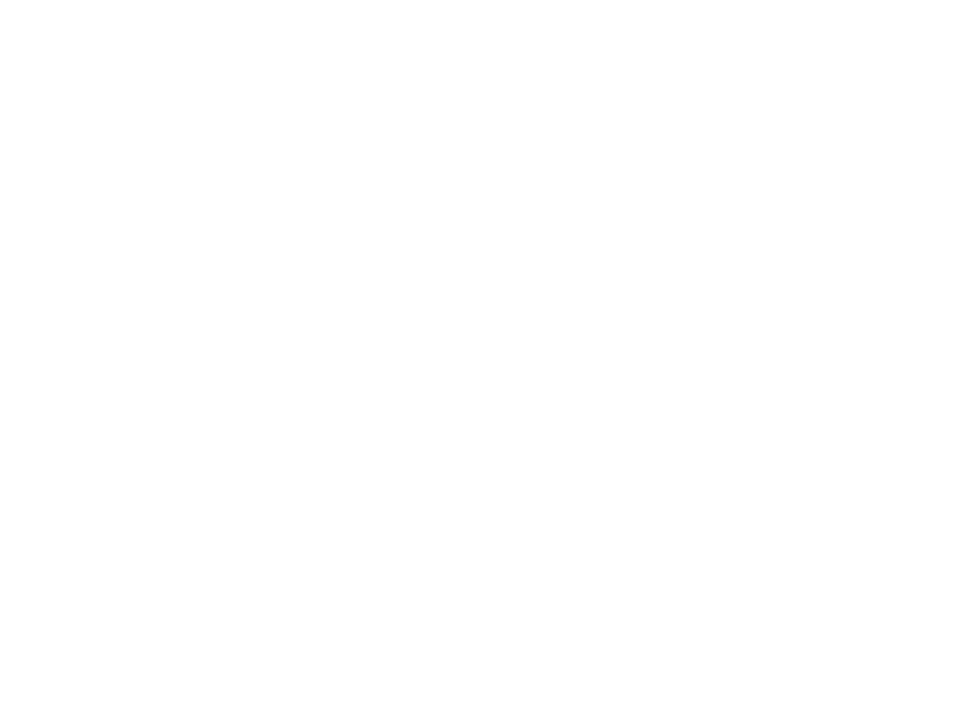

<IPython.core.display.Javascript object>


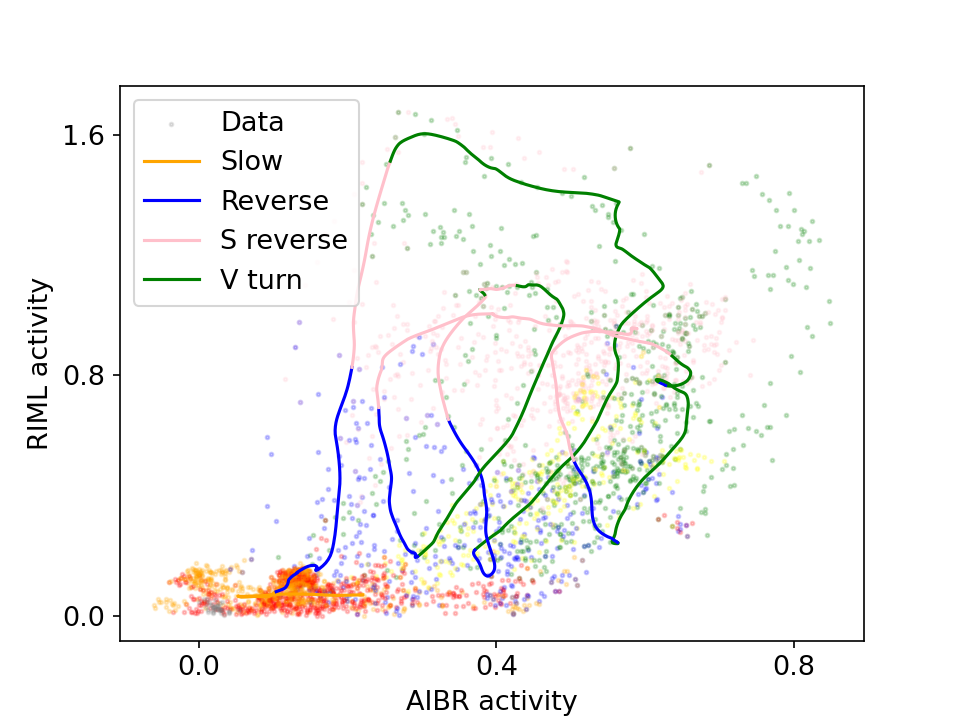

Text(0, 0.5, 'RIML activity')

In [11]:
#2维画图 颜色表示行为 # plot trace in 2D : color corresponding to behavior

#3:see3 0,830,1200,2500,3300,4200,5100,6000  /3200,4300  p:120,900,3650

#3:see1 0,400,1200,2000,2700/3300,4000    p:1450,3300

#3:see2 640 ,2000,3400,4200,5300

def fenduan(tempx):
    for k in range(7):
        if cumleishu[k]<= tempx < cumleishu[k+1]:
            return k+1
    

def learnst(dataofst,tf,use_type=1):
    if use_type==1:
        trst1=torch.zeros(tfie*10,1)
        for i in range(round(tf/100)):
            tempstgo=stgosorted.repeat(100,1,1)
            tempda=dataofst[i*100:i*100+100,:]
            tempda=tempda.repeat(cumleishu[7],1,1).transpose(0,1)
            tempfd=torch.nn.PairwiseDistance(2)
            tempdis=tempfd(tempstgo,tempda)
            tempar=torch.argmin(tempdis,1)
            tempar=tempar.to(torch.device("cpu"))
            for k in range(100):
                trst1[k+i*100]=fenduan(tempar[k])  
    else:
        trst1=(model2(dataofst[:tf,:]).argmax(1)+1).type(torch.int)
    return trst1 
    
    
    
draw3a=False;    
sca_col=[]
tfie=12000
see=5
winl=0
winr=12000
# winl=200
# winr=11400
# winl=0
# winr=11500
# winl=1500
# winr=2500 #fig4c
# j=2
j=0;
name="xxa"+"s"+'%d' %j
locals()["wso"+name]=locals()["w1"+name+"cp"]@traa+cc0

plt.figure(8)

# for tt in range(100):
#     if stpoi[0,tt]==0:
#         break;
# plt.scatter(stpoi[0,0:tt].detach(),stpoi[1,0:tt].detach(),s=10,color="black")

if not draw3a:
    for j in range(jra):
        if not seealltype:
            j=seej
        names="data%d" %j
        linelk,=plt.plot(locals()[names+"cp"][0:recn[j],0:1],locals()[names+"cp"][0:recn[j],1:2],color="gray",alpha=0.8)

if draw3a:
    trst2=learnst(data0.to(dev),recn[j])
    sca_col=[]
    for j in range(jra):
        if not seealltype:
            j=seej
    #     tempj=j+1
    #     names="state%d" %tempj
        names="trst2"
        name2="data%d" %j
        statelas1=locals()[names][0];
        lasswi=0
        for k in range(recn[j]-1):
            if locals()[names][k+1]!=statelas1:
                labeler=statelas1.clone().type(torch.int).item()-1
                namer="linel"+'%d' %labeler
                locals()[namer]=plt.scatter(locals()[name2+"cp"][lasswi:k+2,0],locals()[name2+"cp"][lasswi:k+2,1],s=3,color=colorname[statelas1.clone().type(torch.int).item()-1],alpha=0.2)
                if not labeler in sca_col:
                    sca_col.append(labeler)
                lasswi=k+1
                statelas1=locals()[names][k+1]
        labeler=statelas1.clone().type(torch.int).item()-1
        namer="linel"+'%d' %labeler
        locals()[namer]=plt.scatter(locals()[name2+"cp"][lasswi:k+2,0],locals()[name2+"cp"][lasswi:k+2,1],s=6,color=colorname[statelas1.clone().type(torch.int).item()-1],alpha=0.2)
        if not labeler in sca_col:
            sca_col.append(labeler)


plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("PC1",fontsize=13)
plt.ylabel("PC2",fontsize=13)

ax=plt.gca()
ax.set_xticks([-0.6, 0.1, 0.8])# fig3ar f1a f4a f4c
ax.set_yticks([-0.4, 0, 0.4])# fig3ar f1a f2e1 f4a f4c

plt.ylim(-0.7,0.4) # fig3ar f1a f2e1 f4a f4c
plt.xlim(-0.7,1.2) #fig3ar f1a f4a f4c
# plt.xlim(-0.7,1.3) #f2e1

# plt.ylim(-0.6,0.3) # fig1a fig3a fig8e8f
# plt.xlim(-0.7,0.9) #fig2e1old
# plt.ylim(-0.7,0.3) #fig2e1old

j=simj
i=see
name="xxa"+"s"+'%d' %j
# line2,=plt.plot(locals()["w1"+name][0:tfie,0:1].squeeze(-1),locals()["w1"+name][0:tfie,1:2].squeeze(-1),"red")

trst1=learnst(locals()["w1"+name][:,i,:],winr,1)


# for t in range(winr-winl):
#     if trst1[winl+t]==4 and trst1[winl+t+1]==1:
#         print(locals()["wso"+name][winl+t,i,13],winl+t)

#for cycle2
# for t in range(winr-winl):
#     if winl+t>700 and winl+t+1<11000 and trst1[winl+t]==4 and locals()["wso"+name][winl+t,i,13]<0.72:
#         trst1[winl+t]=7

#for 4a
for t in range(winr-winl):
    if winl+t>3200 and winl+t+1<11000 and trst1[winl+t]==4 and locals()["wso"+name][winl+t,i,13]<0.72:
        trst1[winl+t]=7

        
#for cycle1   and f8
for t in range(winr-winl):
    if trst1[winl+t]==2 and locals()["wso"+name][winl+t,i,13]>1.251:
        trst1[winl+t]=1

if not draw3a:
    plot_col=[]
    statelas2=trst1[winl];
    print(statelas2-1)
    lasswi=winl
    for k in range(winr-1):
        if k<winl:
            continue
        if trst1[k+1]!=statelas2:
            labeler=statelas2.clone().type(torch.int).item()-1
            namer="linel"+'%d' %labeler
            locals()[namer],=plt.plot(locals()["w1"+name+"cp"][lasswi:k+2,i,0:1],locals()["w1"+name+"cp"][lasswi:k+2,i,1:2],color=colorname[labeler])
            if not labeler in plot_col:
                plot_col.append(labeler)
            lasswi=k+1
            statelas2=trst1[k+1]    
    labeler=statelas2.clone().type(torch.int).item()-1
    namer="linel"+'%d' %labeler
    locals()[namer],=plt.plot(locals()["w1"+name+"cp"][lasswi:k+2,i,0:1],locals()["w1"+name+"cp"][lasswi:k+2,i,1:2],color=colorname[labeler])
    if not labeler in plot_col:
        plot_col.append(labeler)
if draw3a:
    j=0
    i=3
    name="xxa"+"s"+'%d' %j
    line_cycle1,=plt.plot(locals()["w1"+name+"cp"][0:12000,i,0:1],locals()["w1"+name+"cp"][0:12000,i,1:2],color="black")
    j=1
    i=1
    name="xxa"+"s"+'%d' %j
    line_cycle2,=plt.plot(locals()["w1"+name+"cp"][200:11400,i,0:1],locals()["w1"+name+"cp"][200:11400,i,1:2],color="cyan")
# linel2,=plt.plot([0,0],[0,0],color=colorname[2])
# line1,=plt.plot(data0[0:3000,0:1],data0[0:3000,1:2],"gray")


# plt.legend([line1,line2],["trace of data","and others: trace simulated using the learned F"])
# plt.legend([line1,line2],["trace of data","trace simulated using the learned F"])
# plt.legend([linelk,line2],["trace of data","trace simulated"])

if not draw3a:
    tempar1=[linelk]
    tempar2=["Trace of data"]##
else:
    tempar1=[]
    tempar2=[]
Reverse_down=False
if draw3a:
    true_plotarray=range(7)
else:
    true_plotarray=plotarray

for i in plotarray:
# for i in [6,3,4]:
# for i in [1,0,4,6,3,2]:
# for i in [1,4,6,3,0]:
    name="linel%d" %i
    if i in plot_col and not draw3a:
        if i==4:
            Reverse_down=True
        if i==5 and Reverse_down:
            continue
        tempar1.append(locals()[name])
        tempar2.append(staten[i])
    if i in sca_col and draw3a:
        if i==4:
            Reverse_down=True
        if i==5 and Reverse_down:
            continue
        tempar1.append(locals()[name])
        tempar2.append(staten[i])

if draw3a:
    tempar1.append(line_cycle1)
    tempar2.append("Cycle 1")
    tempar1.append(line_cycle2)
    tempar2.append("Cycle 2")
plt.legend(tempar1,tempar2,fontsize=13)

# plt.legend([line1,line2],["line: data","point:attractor points"])

winlt=winl/10/fps
winrt=winr/10/fps

# plt.title("trace simulated,t between  "+'%.2f' %winlt + "s"+" and " +'%.2f' %winrt + " s")

# savefig_path="./lastout/out-ori/8e"
# plt.savefig(savefig_path+".pdf",dpi=500)
# plt.savefig(savefig_path+".tif",dpi=500)






nes=13

plt.figure(9)
fig, ax_time=plt.subplots()
ax_time.spines['right'].set_visible(False)
ax_time.spines['top'].set_visible(False)
j=simj
i=see

move=0              ##560
movet=torch.zeros(5,1);
if not shwtyp:
    trant=10
    movet[0]=move/fps/10
else:
    trant=delta1/delta2
    for j in range(5):
        movet[j]=move/fpsarr[j]*(delta2/delta1)
for j in range(5):
    kcou[:,j]=torch.tensor(range(500000))
    kcou1[:,j]=torch.tensor(range(500000))
if not shwtyp:
    for j in range(5):
        kcou[:,j]=(kcou[:,j]+move)/fpsarr[j]/10
else:
    for j in range(5):
        kcou[:,j]=(kcou[:,j]+move)/fpsarr[j]*(delta2/delta1)

for j in range(5):
    kcou1[:,j]=(kcou1[:,j]+move)/fpsarr[j] 
    

for j in range(jra):
    if not seealltype:
        j=seej
    names="%d" %j
    locals()["datasol"+names]=locals()["data"+names+"cp"]@traa+cc0

print(kcou[:,0])

print(kcou1[:,0])

for j in range(jra):
    if not seealltype:
        j=seej
    names="datasol%d" %j
    linelk,=plt.plot(kcou1[0:round(tfie/trant),j],locals()[names][i*50:i*50+round(tfie/trant),nes],color="gray",alpha=0.5)


# print(locals()[names][i*50,nes])

# linelk,=plt.plot(kcou1[0:round(tfie/10),0],datasol0[i*50:i*50+round(tfie/10),nes],color="gray",alpha=0.5)

# statelas1=state1[i*50];
# lasswi=0
# for k in range(round(tfie/10)):
#     if state1[i*50+k+1]!=statelas1:
#         plt.plot(kcou1[lasswi:k+2,0:1],datasol0[lasswi+i*50:i*50+k+2,nes],color=colorname[statelas1.clone().type(torch.int).item()-1],alpha=0.4)
#         lasswi=k+1
#         statelas1=state1[i*50+k+1]


plot_col=[]    
j=simj
statelas2=trst1[winl];
lasswi=winl
name="xxa"+"s"+'%d' %j
locals()["wso"+name]=locals()["w1"+name+"cp"]@traa+cc0
#old
# plt.ylim(0,2.2) #fig1c1
# plt.ylim(0.3,2) #fig1c2
# plt.xlim(0,500) # fig2e2
# plt.xlim(0,470) # fig4a,fig4c
# plt.xlim(0,420)#fig1c

#new
# plt.xlim(0,500) #fig1d
# plt.ylim(0,2.5)  #fig1d
# ax_time.set_xticks([0, 200, 400])#f1d
# ax_time.set_yticks([0, 1.0, 2.0])#f1d

# plt.xlim(0,400) #fig1e
# plt.ylim(0.3,2.1)  #fig1e
# ax_time.set_xticks([0, 200, 400])#f1e
# ax_time.set_yticks([0.4, 1.2, 2.0])#f1e
# winl=0 #f1e

# plt.xlim(0,550) # fig2e2
# ax_time.set_xticks([0, 200, 400])#f2e2
# ax_time.set_yticks([0, 1.0, 2.0])#f2e2

plt.xlim(0,500) # fig4a2
plt.ylim(-0.1,2.2) # fig4a2
ax_time.set_xticks([0, 200, 400])#f4a2
ax_time.set_yticks([0, 1.0, 2.0])#f4a2

for k in range(winr-1):
    if trst1[k+1]!=statelas2:
        if k<winl:
            continue
        labeler=statelas2.clone().type(torch.int).item()-1
        namer="linel"+'%d' %labeler
        locals()[namer],=plt.plot(kcou[lasswi:k+2,j],locals()["wso"+name][lasswi:k+2,i,nes],color=colorname[labeler])
        if not labeler in plot_col:
            plot_col.append(labeler)
        lasswi=k+1
        statelas2=trst1[k+1]   
labeler=statelas2.clone().type(torch.int).item()-1
namer="linel"+'%d' %labeler
locals()[namer],=plt.plot(kcou[lasswi:k+2,j],locals()["wso"+name][lasswi:k+2,i,nes],color=colorname[labeler])   
if not labeler in plot_col:
    plot_col.append(labeler)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("Time(s)",fontsize=13)
plt.ylabel(nename[nes]+" activity",fontsize=13)
tempar1=[linelk]
tempar2=["Trace of data"]
print(plot_col)
# tempar1=[]
# tempar2=[]
Reverse_down=False
# for i in plotarray:
# for i in [6,3,4]:
# for i in [1,0,4,6,3,2]:
for i in [1,4,6,3,0]:
    name="linel%d" %i
    if i in plot_col:
        if i==4:
            Reverse_down=True
        if i==5 and Reverse_down:
            continue
        tempar1.append(locals()[name])
        tempar2.append(staten[i])
plt.legend(tempar1,tempar2,fontsize=13)
# plt.legend([line1,line2],["transparent means data","solid means simulated"])


    
# plt.title("trace simulated,moved \n through t axes "+'%.2f' %movet + "s")
# plt.savefig("./pic/show5/5.png",dpi=500)

# savefig_path="./lastout/out-ori/4a2"
# plt.savefig(savefig_path+".pdf",dpi=500)
# plt.savefig(savefig_path+".tif",dpi=500)

# ,loc="upper right"







# pic5a 6 4
#pic5d 13 4
#pic6a 0 12
#pic6b 0 13
#pic7a 3 11
#pic7b 6 8
#pic7c 7 11
#pic7d 1 10
ne1=1
ne2=10
# ne3=13

plt.figure(1010)
fig, ax=plt.subplots()

# ax.set_xticks([0, 0.6, 1.2])#f5a
# ax.set_yticks([0, 0.7, 1.4])#f5a

# ax.set_xticks([0, 1, 2])#f5c
# ax.set_yticks([0, 0.7, 1.4])#f5c


# ax.set_xticks([0, 0.6, 1.2])#f6a
# ax.set_yticks([0, 0.6, 1.2])#f6a
# winl=500 #f6a
# plt.xlim(-0.27,1.3)  #f6a

# ax.set_xticks([0, 0.6, 1.2])#f6b
# ax.set_yticks([0, 1, 2])#f6b
# winl=500 #f6b
# plt.xlim(-0.27,1.3)  #f6b

# ax.set_xticks([0, 0.6, 1.2])#f7a
# ax.set_yticks([0, 1.1, 2.2])#f7a
# winl=500 #f7a
# plt.ylim(-0.15,2.5)  #f7a

# ax.set_xticks([0, 0.6, 1.2])#f7b
# ax.set_yticks([0, 0.25, 0.5])#f7b
# winl=500 #f7b


# ax.set_xticks([0, 0.3, 0.6])#f7c
# ax.set_yticks([0, 1.1, 2.2])#f7c
# winl=500 #f7c

ax.set_xticks([0, 0.4, 0.8])#f7d
ax.set_yticks([0, 0.8, 1.6])#f7d
winl=500 #f7d




# plt.plot(datasol0[0:tfie,ne1],datasol0[0:tfie,ne2],"gray")
trst2=learnst(data0.to(dev),recn[j])

for j in range(jra):
    if not seealltype:
        j=seej
#     tempj=j+1
#     names="state%d" %tempj
    names="trst2"
    name2="datasol%d" %j
    statelas1=locals()[names][0];
    lasswi=0
    for k in range(recn[j]-1):
        if locals()[names][k+1]!=statelas1:
            plt.scatter(locals()[name2][lasswi:k+2,ne1],locals()[name2][lasswi:k+2,ne2],s=3,color=colorname[statelas1.clone().type(torch.int).item()-1],alpha=0.2)
            lasswi=k+1
            statelas1=locals()[names][k+1]
    linelk=plt.scatter(locals()[name2][lasswi:k+2,ne1],locals()[name2][lasswi:k+2,ne2],s=3,color=colorname[statelas1.clone().type(torch.int).item()-1],alpha=0.2)


# j=2        
i=see
name="xxa"+"s"+'%d' %j
locals()["wso"+name]=locals()["w1"+name+"cp"]@traa+cc0


plot_col=[]
statelas2=trst1[winl];
lasswi=winl
for k in range(winr-1):
    if trst1[k+1]!=statelas2:    
        if k<winl:
            continue
        labeler=statelas2.clone().type(torch.int).item()-1
        namer="linel"+'%d' %labeler
        locals()[namer],=plt.plot(locals()["wso"+name][lasswi:k+2,i,ne1],locals()["wso"+name][lasswi:k+2,i,ne2],color=colorname[labeler])
        if not labeler in plot_col:
            plot_col.append(labeler)
        lasswi=k+1
        statelas2=trst1[k+1]   
labeler=statelas2.clone().type(torch.int).item()-1
namer="linel"+'%d' %labeler
locals()[namer],=plt.plot(locals()["wso"+name][lasswi:k+2,i,ne1],locals()["wso"+name][lasswi:k+2,i,ne2],color=colorname[labeler])
if not labeler in plot_col:
    plot_col.append(labeler)

# plpo1=plt.scatter(locals()["wso"+name][winl,ne1],locals()["wso"+name][winl,ne2],color="black")
# plpo2=plt.scatter(locals()["wso"+name][winr-1,ne1],locals()["wso"+name][winr-1,ne2],color="purple")

# plpo1.set_zorder(2)
# plpo2.set_zorder(2)

# plt.legend([linel0,linel1,linel2,linel3,linel4,linel6,plpo1,plpo2],["Forward","Slow","D turn","V turn","Reverse","S reverse","Trace start","Trace end"],loc="upper left")

tempar1=[linelk]
tempar2=["Data"]
Reverse_down=False
for i in plotarray:
# for i in [6,3,4]:    
    name="linel%d" %i
    if i in plot_col:
        if i==4:
            Reverse_down=True
        if i==5 and Reverse_down:
            continue
        tempar1.append(locals()[name])
        tempar2.append(staten[i])
plt.legend(tempar1,tempar2,fontsize=13)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel(nename[ne1]+" activity",fontsize=13)
plt.ylabel(nename[ne2]+" activity",fontsize=13)
# plt.xlim(-0.195,1.3)#pic6
# plt.xlim(-0.199,0.95)#pic7d

# savefig_path="./lastout/out-ori/7d1"
# plt.savefig(savefig_path+".pdf",dpi=500)
# plt.savefig(savefig_path+".tif",dpi=500)





# plt.savefig("./pic/show5/19.png",dpi=500)

## 6 4,8 5,12 8, 13 4

tensor([[7.],
        [7.],
        [7.],
        ...,
        [0.],
        [0.],
        [0.]])


In [48]:
print(sca_col)

[3]


In [46]:
# see=29
# i=see
# j=0
# name="xxa"+"s"+'%d' %j
# savetr=np.array(locals()["w1"+name+"cp"][winl:winr,:,:])
# io.savemat("./lastout/5/dis_ne=13-simnu=16.mat",{"cy1":savetr}) 


# savest=np.array(trst1)
# io.savemat("./attrpo/tr/cymod3/cycle5st.mat",{"tr2st":savest}) 

In [12]:
def fenduan(tempx):
    for k in range(7):
        if cumleishu[k]<= tempx < cumleishu[k+1]:
            return k+1
def learnst(dataofst,tf,use_type=1):
    if use_type==1:
        trst1=torch.zeros(tfie*10,1)
        for i in range(round(tf/100)):
            tempstgo=stgosorted.repeat(100,1,1)
            tempda=dataofst[i*100:i*100+100,:]
            tempda=tempda.repeat(cumleishu[7],1,1).transpose(0,1)
            tempfd=torch.nn.PairwiseDistance(2)
            tempdis=tempfd(tempstgo,tempda)
            tempar=torch.argmin(tempdis,1)
            tempar=tempar.to(torch.device("cpu"))
            for k in range(100):
                trst1[k+i*100]=fenduan(tempar[k])  
    else:
        trst1=(model2(dataofst[:tf,:]).argmax(1)+1).type(torch.int)
    return trst1 

In [51]:
# extra work 1: calculate state transition probability in different noise level

test_D=1e-2
#模拟曲线模块
my_raodong=0
dis_ne=0
simnu=60
simj=0
j=0
name1="data"+'%d' %j
x1=torch.zeros(simnu,dim)
for i in range(simnu):
    start=50*i
    x1[i,:]=locals()[name1][start]
x1=x1.to(dev)
k=0
name="xxa"+"s"+'%d' %j
locals()["w1"+name]=torch.zeros(100000,simnu,dim).to(dev)
stopsig=0
with torch.no_grad():
    for t in range(36000):
        x1=x1+(model(x1)-x1*del2)*delta2/fpsarr[0]
        if t%segm==segm-1:
            rd=torch.randn(simnu,dim)*math.sqrt(delta2/delta1/segm*test_D)
            rd=rd.to(dev)
            x1=x1+rd
            locals()["w1"+name][k,:,:]=x1.detach()
            k=k+1
            if t%1000==999:
                print(t)
locals()["w1"+name+"cp"]=locals()["w1"+name].to(torch.device("cpu"))


2999
5999
8999
11999
14999
17999
20999
23999
26999
29999
32999
35999


In [52]:
# extra work 1: calculate state transition probability in different noise level
tran_p=torch.zeros(7,7)
for i in range(simnu):
    trst1=learnst(locals()["w1"+name][:,i,:],winr,2)
    trst11=trst1[2000:11000-1]
    trst2=trst1[2001:11000]
    trstdel=trst11-trst2
    for ind in torch.nonzero(trstdel):
        ind=ind[0]
        state1=trst11[ind]
        state2=trst2[ind]
        labeler1=state1.clone().type(torch.int).item()-1
        labeler2=state2.clone().type(torch.int).item()-1
        tran_p[labeler1][labeler2]=tran_p[labeler1][labeler2]+1
    if i%10 == 0:
        print(i)
print(tran_p)

0
10
20
30
40
50
tensor([[   0.,   74.,   19.,   49.,   20.,   28.,    0.],
        [  67.,    0.,  355.,  672.,  191.,  760.,  652.],
        [  29.,  362.,    0., 1759., 1169., 2090., 1930.],
        [  52.,  672., 1833.,    0., 2262.,  102., 4610.],
        [  19.,  194., 1170., 2199.,    0., 2321., 3767.],
        [  24.,  756., 2027.,  102., 2310.,    0., 5973.],
        [   0.,  640., 1937., 4750., 3708., 5894.,    0.]])


In [40]:
tran_p_save=torch.zeros(5,7,7)

In [53]:
tran_p_save[4,:,:]=tran_p

In [19]:
print([1e-6*math.pow(1.5,i) for i in range(30)])

[1e-06, 1.5e-06, 2.25e-06, 3.375e-06, 5.062499999999999e-06, 7.59375e-06, 1.1390624999999999e-05, 1.7085937499999998e-05, 2.562890625e-05, 3.8443359375e-05, 5.76650390625e-05, 8.649755859375e-05, 0.00012974633789062499, 0.0001946195068359375, 0.0002919292602539062, 0.00043789389038085934, 0.000656840835571289, 0.0009852612533569336, 0.0014778918800354003, 0.0022168378200531007, 0.0033252567300796508, 0.004987885095119476, 0.0074818276426792145, 0.011222741464018821, 0.01683411219602823, 0.025251168294042347, 0.03787675244106352, 0.056815128661595285, 0.08522269299239292, 0.12783403948858937]


In [23]:
#extra work1:final

# D_set=[1e-6,3e-6,6e-6,1e-5,3e-5,6e-5,1e-4,3e-4,6e-4,1e-3,3e-3,6e-3,1e-2,3e-2,6e-2,1e-1,3e-1,6e-1,1e-0] #tranp6
D_set=[1e-6*math.pow(1.5,i) for i in range(30)]  #tranp7
D_set_num=len(D_set)
tran_p_save=torch.zeros(D_set_num,7,7)
tranline_p_save=torch.zeros(D_set_num,7)
for l in range(D_set_num):
    test_D=D_set[l]  
    my_raodong=0
    dis_ne=0
    simnu=60
    simj=0
    j=0
    name1="data"+'%d' %j
    x1=torch.zeros(simnu,dim)
    for i in range(simnu):
        start=50*i
        x1[i,:]=locals()[name1][start]
    x1=x1.to(dev)
    k=0
    name="xxa"+"s"+'%d' %j
    locals()["w1"+name]=torch.zeros(100000,simnu,dim).to(dev)
    stopsig=0
    with torch.no_grad():
        for t in range(36000):
            x1=x1+(model(x1)-x1*del2)*delta2/fpsarr[0]
            if t%segm==segm-1:
                rd=torch.randn(simnu,dim)*math.sqrt(delta2/delta1/segm*test_D)
                rd=rd.to(dev)
                x1=x1+rd
                locals()["w1"+name][k,:,:]=x1.detach()
                k=k+1
                if t%3000==2999:
                    print(l,test_D,t)
    locals()["w1"+name+"cp"]=locals()["w1"+name].to(torch.device("cpu"))
    tran_p=torch.zeros(7,7)
    tranline_p=torch.zeros(7)
    for i in range(simnu):
        trst1=learnst(locals()["w1"+name][:,i,:],winr,2)
        trst11=trst1[2000:10000]
        [temp_ele,temp_count]=torch.unique(trst1,return_counts=True)
        tranline_p[temp_ele.type(torch.long)-1]=tranline_p[temp_ele.type(torch.long)-1]+temp_count
        trst11=trst1[2000:11000-1]
        trst2=trst1[2001:11000]
        trstdel=trst11-trst2
        for ind in torch.nonzero(trstdel):
            ind=ind[0]
            state1=trst11[ind]
            state2=trst2[ind]
            labeler1=state1.clone().type(torch.int).item()-1
            labeler2=state2.clone().type(torch.int).item()-1
            tran_p[labeler1][labeler2]=tran_p[labeler1][labeler2]+1
    tran_p_save[l,:,:]=tran_p
    tranline_p_save[l,:]=tranline_p
    print(l,test_D,tran_p)

0 1e-06 2999
0 1e-06 5999
0 1e-06 8999
0 1e-06 11999
0 1e-06 14999
0 1e-06 17999
0 1e-06 20999
0 1e-06 23999
0 1e-06 26999
0 1e-06 29999
0 1e-06 32999
0 1e-06 35999
0 1e-06 tensor([[  0., 759.,   0.,   0.,   0.,   0.,   0.],
        [754.,   0.,   0.,   2.,  15.,   2.,   0.],
        [  2.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  4.,  10.,   0.,   0.,   3.,   0.,   0.],
        [  1.,   1.,   0.,   0.,   0.,   0.,  16.],
        [  0.,   1.,   0.,   0.,   0.,   0.,   1.],
        [  0.,   0.,   1.,  15.,   0.,   0.,   0.]])
1 1.5e-06 2999
1 1.5e-06 5999
1 1.5e-06 8999
1 1.5e-06 11999
1 1.5e-06 14999
1 1.5e-06 17999
1 1.5e-06 20999
1 1.5e-06 23999
1 1.5e-06 26999
1 1.5e-06 29999
1 1.5e-06 32999
1 1.5e-06 35999
1 1.5e-06 tensor([[  0., 834.,   0.,   0.,   0.,   1.,   0.],
        [831.,   0.,   0.,   0.,  16.,   2.,   0.],
        [  2.,   0.,   0.,   0.,   0.,   0.,   1.],
        [  5.,  11.,   0.,   0.,   1.,   0.,   0.],
        [  2.,   0.,   0.,   0.,   0.,   0.,  16.],
   

7 1.7085937499999998e-05 2999
7 1.7085937499999998e-05 5999
7 1.7085937499999998e-05 8999
7 1.7085937499999998e-05 11999
7 1.7085937499999998e-05 14999
7 1.7085937499999998e-05 17999
7 1.7085937499999998e-05 20999
7 1.7085937499999998e-05 23999
7 1.7085937499999998e-05 26999
7 1.7085937499999998e-05 29999
7 1.7085937499999998e-05 32999
7 1.7085937499999998e-05 35999
7 1.7085937499999998e-05 tensor([[0.000000000000000e+00, 1.410000000000000e+03, 4.000000000000000e+00,
         6.000000000000000e+00, 1.000000000000000e+00, 1.000000000000000e+00,
         0.000000000000000e+00],
        [1.403000000000000e+03, 0.000000000000000e+00, 0.000000000000000e+00,
         6.000000000000000e+00, 3.600000000000000e+01, 1.800000000000000e+01,
         0.000000000000000e+00],
        [1.200000000000000e+01, 0.000000000000000e+00, 0.000000000000000e+00,
         1.000000000000000e+00, 0.000000000000000e+00, 0.000000000000000e+00,
         4.900000000000000e+01],
        [1.300000000000000e+01, 2.10000

12 0.00012974633789062499 2999
12 0.00012974633789062499 5999
12 0.00012974633789062499 8999
12 0.00012974633789062499 11999
12 0.00012974633789062499 14999
12 0.00012974633789062499 17999
12 0.00012974633789062499 20999
12 0.00012974633789062499 23999
12 0.00012974633789062499 26999
12 0.00012974633789062499 29999
12 0.00012974633789062499 32999
12 0.00012974633789062499 35999
12 0.00012974633789062499 tensor([[0.000000000000000e+00, 3.969000000000000e+03, 4.010000000000000e+02,
         5.000000000000000e+00, 1.600000000000000e+01, 4.840000000000000e+02,
         0.000000000000000e+00],
        [3.965000000000000e+03, 0.000000000000000e+00, 1.400000000000000e+01,
         3.000000000000000e+01, 8.200000000000000e+01, 8.400000000000000e+01,
         0.000000000000000e+00],
        [4.240000000000000e+02, 1.300000000000000e+01, 0.000000000000000e+00,
         2.500000000000000e+01, 2.000000000000000e+00, 8.050000000000000e+02,
         2.890000000000000e+02],
        [1.200000000000000

20 0.0033252567300796508 2999
20 0.0033252567300796508 5999
20 0.0033252567300796508 8999
20 0.0033252567300796508 11999
20 0.0033252567300796508 14999
20 0.0033252567300796508 17999
20 0.0033252567300796508 20999
20 0.0033252567300796508 23999
20 0.0033252567300796508 26999
20 0.0033252567300796508 29999
20 0.0033252567300796508 32999
20 0.0033252567300796508 35999
20 0.0033252567300796508 tensor([[   0.,   32.,   24.,   20.,   11.,   10.,    0.],
        [  33.,    0.,  132.,  170.,   88.,  101.,   29.],
        [  26.,  122.,    0., 1073.,  652., 1234., 1576.],
        [  20.,  183., 1096.,    0., 1089.,    8., 2349.],
        [   8.,   87.,  651.,  961.,    0.,  496., 2293.],
        [  10.,   99., 1136.,    8.,  512.,    0., 3705.],
        [   0.,   30., 1642., 2511., 2140., 3616.,    0.]])
21 0.004987885095119476 2999
21 0.004987885095119476 5999
21 0.004987885095119476 8999
21 0.004987885095119476 11999
21 0.004987885095119476 14999
21 0.004987885095119476 17999
21 0.0049878850

29 0.12783403948858937 17999
29 0.12783403948858937 20999
29 0.12783403948858937 23999
29 0.12783403948858937 26999
29 0.12783403948858937 29999
29 0.12783403948858937 32999
29 0.12783403948858937 35999
29 0.12783403948858937 tensor([[0.000000000000000e+00, 1.006000000000000e+03, 1.930000000000000e+02,
         3.870000000000000e+02, 1.190000000000000e+02, 7.420000000000000e+02,
         3.000000000000000e+00],
        [9.880000000000000e+02, 0.000000000000000e+00, 9.690000000000000e+02,
         5.030000000000000e+03, 1.303000000000000e+03, 7.063000000000000e+03,
         3.387000000000000e+03],
        [1.900000000000000e+02, 9.730000000000000e+02, 0.000000000000000e+00,
         1.716000000000000e+03, 4.900000000000000e+02, 2.296000000000000e+03,
         9.750000000000000e+02],
        [3.940000000000000e+02, 5.015000000000000e+03, 1.660000000000000e+03,
         0.000000000000000e+00, 3.348000000000000e+03, 8.860000000000000e+02,
         4.596000000000000e+03],
        [1.2700000

In [29]:
savetp=np.array(tran_p_save)
savelinetp=np.array(tranline_p_save)
io.savemat("./lastout/extra/tranp7.mat",{"tranp":savetp,"tranlinep":savelinetp})

In [30]:
#extra work2 : calculate state probability for different inhibitions
# neuron_set=[-1,2,4,6]
neuron_set=[-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13]
neu_num=len(neuron_set)
line_p_save=torch.zeros(neu_num,7)
test_D=6e-4
dis_coe=0.1
for l in range(neu_num):
    dis_ne=neuron_set[l]  
    simnu=60
    simj=0
    j=0
    name1="data"+'%d' %j
    x1=torch.zeros(simnu,dim)
    for i in range(simnu):
        start=50*i
        x1[i,:]=locals()[name1][start]
    x1=x1.to(dev)
    k=0
    name="xxa"+"s"+'%d' %j
    locals()["w1"+name]=torch.zeros(100000,simnu,dim).to(dev)
    stopsig=0
    with torch.no_grad():
        dis_e=torch.zeros(dim,1)
        dis_e[dis_ne]=1
        dis_coe1=cc0@dis_e
        dis_coe1=dis_coe1.item()
        dis_tr=traa@dis_e
        dis_tr2=dis_e.T@trab
        dis_e=dis_e.to(dev)
        dis_tr=dis_tr.to(dev)
        dis_tr2=dis_tr2.to(dev)
        dis_coe2=dis_tr.T@dis_tr
        dis_coe2=dis_coe2.item()
        if dis_ne<0:
            dis_tr2=dis_tr2*0
        for t in range(36000):
            x1=x1+(model(x1)-x1*del2-10*(x1@dis_tr+dis_coe1)*dis_tr2*dis_coe)*delta2/fpsarr[0]
            if t%segm==segm-1:
                rd=torch.randn(simnu,dim)*math.sqrt(delta2/delta1/segm*test_D)
                rd=rd.to(dev)
                x1=x1+rd
                locals()["w1"+name][k,:,:]=x1.detach()
                k=k+1
                if t%3000==2999:
                    print(l,test_D,t)
    locals()["w1"+name+"cp"]=locals()["w1"+name].to(torch.device("cpu"))
    line_p=torch.zeros(7)
    for i in range(simnu):
        trst1=learnst(locals()["w1"+name][:,i,:],winr,2)
        trst11=trst1[2000:10000]
        [temp_ele,temp_count]=torch.unique(trst1,return_counts=True)
        line_p[temp_ele.type(torch.long)-1]=line_p[temp_ele.type(torch.long)-1]+temp_count
    line_p_save[l,:]=line_p
    print(l,dis_ne,line_p)

0 0.0006 2999
0 0.0006 5999
0 0.0006 8999
0 0.0006 11999
0 0.0006 14999
0 0.0006 17999
0 0.0006 20999
0 0.0006 23999
0 0.0006 26999
0 0.0006 29999
0 0.0006 32999
0 0.0006 35999
0 -1 tensor([111317., 108545.,  66937.,  67795.,  36948.,  35708., 256750.])
1 0.0006 2999
1 0.0006 5999
1 0.0006 8999
1 0.0006 11999
1 0.0006 14999
1 0.0006 17999
1 0.0006 20999
1 0.0006 23999
1 0.0006 26999
1 0.0006 29999
1 0.0006 32999
1 0.0006 35999
1 0 tensor([ 31391.,  61962.,   1599.,   1940., 186165., 116311., 284632.])
2 0.0006 2999
2 0.0006 5999
2 0.0006 8999
2 0.0006 11999
2 0.0006 14999
2 0.0006 17999
2 0.0006 20999
2 0.0006 23999
2 0.0006 26999
2 0.0006 29999
2 0.0006 32999
2 0.0006 35999
2 1 tensor([1.076400000000000e+04, 4.813200000000000e+04, 1.700000000000000e+02,
        1.965000000000000e+03, 6.530000000000000e+02, 6.057100000000000e+04,
        5.617450000000000e+05])
3 0.0006 2999
3 0.0006 5999
3 0.0006 8999
3 0.0006 11999
3 0.0006 14999
3 0.0006 17999
3 0.0006 20999
3 0.0006 23999
3 0.0006 

In [28]:
torch.set_printoptions(precision=2)
for l in range(neu_num):
    dis_ne=neuron_set[l]  
    line_p=line_p_save[l,:]
    line_p=line_p/line_p.sum()
    print(dis_ne,line_p)
torch.set_printoptions(precision=15)

-1 tensor([0.18, 0.18, 0.09, 0.09, 0.05, 0.05, 0.36])
0 tensor([0.03, 0.05, 0.00, 0.00, 0.38, 0.18, 0.35])
1 tensor([1.36e-02, 8.33e-02, 6.43e-04, 3.66e-03, 7.00e-04, 7.55e-02, 8.23e-01])
2 tensor([0.16, 0.20, 0.05, 0.22, 0.05, 0.04, 0.29])
3 tensor([0.27, 0.16, 0.06, 0.20, 0.24, 0.04, 0.03])
4 tensor([0.28, 0.09, 0.01, 0.30, 0.19, 0.03, 0.10])
5 tensor([0.33, 0.02, 0.07, 0.11, 0.09, 0.02, 0.36])
6 tensor([0.03, 0.03, 0.16, 0.17, 0.05, 0.16, 0.42])
7 tensor([0.17, 0.03, 0.02, 0.00, 0.03, 0.05, 0.69])
8 tensor([0.06, 0.03, 0.15, 0.12, 0.07, 0.07, 0.51])
9 tensor([0.07, 0.17, 0.08, 0.12, 0.03, 0.05, 0.48])
10 tensor([0.09, 0.06, 0.01, 0.00, 0.01, 0.73, 0.11])
11 tensor([0.03, 0.07, 0.03, 0.07, 0.53, 0.11, 0.14])
12 tensor([0.05, 0.14, 0.20, 0.01, 0.00, 0.08, 0.51])
13 tensor([0.08, 0.08, 0.06, 0.02, 0.01, 0.07, 0.68])


In [31]:
torch.set_printoptions(precision=2)
for l in range(neu_num):
    dis_ne=neuron_set[l]  
    line_p=line_p_save[l,:]
    line_p=line_p/line_p.sum()
    print(dis_ne,line_p)
torch.set_printoptions(precision=15)

-1 tensor([0.16, 0.16, 0.10, 0.10, 0.05, 0.05, 0.38])
0 tensor([0.05, 0.09, 0.00, 0.00, 0.27, 0.17, 0.42])
1 tensor([1.57e-02, 7.04e-02, 2.49e-04, 2.87e-03, 9.55e-04, 8.86e-02, 8.21e-01])
2 tensor([0.19, 0.21, 0.04, 0.20, 0.05, 0.03, 0.27])
3 tensor([0.27, 0.17, 0.04, 0.21, 0.26, 0.03, 0.03])
4 tensor([0.25, 0.06, 0.02, 0.34, 0.18, 0.04, 0.11])
5 tensor([0.34, 0.02, 0.06, 0.09, 0.09, 0.02, 0.38])
6 tensor([0.03, 0.02, 0.15, 0.14, 0.05, 0.16, 0.44])
7 tensor([0.17, 0.04, 0.02, 0.00, 0.03, 0.05, 0.68])
8 tensor([0.05, 0.02, 0.16, 0.11, 0.07, 0.07, 0.53])
9 tensor([0.05, 0.14, 0.08, 0.13, 0.04, 0.04, 0.51])
10 tensor([0.09, 0.05, 0.01, 0.00, 0.01, 0.74, 0.11])
11 tensor([0.04, 0.09, 0.03, 0.07, 0.51, 0.12, 0.15])
12 tensor([0.04, 0.11, 0.23, 0.00, 0.00, 0.10, 0.52])
13 tensor([0.11, 0.09, 0.06, 0.02, 0.00, 0.06, 0.66])


In [32]:
savetp=np.array(line_p_save)
io.savemat("./lastout/extra/linep2_2.mat",{"linep":savetp})

In [13]:
# esti D

my_loss_fn = torch.nn.MSELoss(reduction='sum')
i=tr_num_learn
name="data"+'%d' %i
with torch.no_grad():
    xpre=locals()[name][0:reclen[i]-ss-2].to(dev)
    for j in range(segm):
        xpre=xpre+(model(xpre)-xpre*del2)*delta1/fpsarr[i]
    temp1=locals()[name][1:reclen[i]-ss-2+1]
    my_temp_D = my_loss_fn(temp1,xpre.to(torch.device("cpu")))*(fpsarr[i]/2)/dim/(reclen[i]-ss-3)

print(my_temp_D)
        
my_D=my_temp_D.to(dev)

tensor(0.000640914018732)


In [162]:
# train the attraction and sigma 




simnu=60
for j in range(kra):
    if not simtype:
        j=simj
    name1="data"+'%d' %j
    x1=torch.zeros(simnu,dim)
    temp5=torch.zeros(simnu)
    for i in range(simnu):
        start=50*i
        x1[i,:]=locals()[name1][start]
    x1=x1.to(dev)
    sigmae=torch.zeros(simnu,dim,dim).to(dev)
    my_I=torch.eye(dim).to(dev)
    my_A=torch.zeros(simnu,dim,dim).to(dev)
    k=0
    name="xxa"+"s"+'%d' %j
    locals()["w1"+name]=torch.zeros(50000,simnu,dim)
    locals()["simsigma"+name]=torch.zeros(50000,simnu,dim,dim)
    for temp3 in range(simnu):
        sigmae[temp3]=my_I*my_D
    for t in range(36000):
#         x1.requires_grad=True
#         for j in range(dim):
#             y1=model(x1)-del2*x1
#             if j>0:
#                 x1.grad.zero_()
#             y1jsum=torch.sum(y1[:,j])
#             y1jsum.backward()
#             my_A[:,j,:]=x1.grad
        with torch.no_grad():
#             sigmae=sigmae+(sigmae@torch.transpose(my_A,1,2)+my_A@sigmae+2*my_D/segm/delta1*my_I)*delta2
            x1=x1+(model(x1)-x1*del2)*delta2
            if t%segm==segm-1:
                locals()["w1"+name][k,:,:]=x1.detach()
                if k%50 == 49: 
                    for j in range(simnu):
                        if torch.dist(locals()["w1"+name][k,j,:],locals()["w1"+name][k-40,j,:])>1e-4:
                            temp5[j]=0
                        if torch.dist(locals()["w1"+name][k,j,:],locals()["w1"+name][k-40,j,:])<1e-4 and temp5[j]<1:
                            print(k,j,locals()["w1"+name][k,j,:])
                            temp5[j]=2
                k=k+1
                if t%1000==999:
                    print(t,"wow")
    locals()["w1"+name+"cp"]=locals()["w1"+name].to(torch.device("cpu"))

stopk=0

for j in range(simnu):
    if temp5[j]>1:
        stopk=stopk+1
print(stopk)


199 12 tensor([-0.587345361709595,  0.187760725617409,  0.082177504897118,
         0.434640020132065, -0.251423686742783, -0.090733870863914,
         0.015469253063202, -0.002353208838031,  0.041046481579542,
        -0.035256970673800,  0.028578229248524, -0.026484278962016,
         0.015790166333318, -0.004806162323803])
199 16 tensor([ 9.035912156105042e-02, -9.017639607191086e-02,  3.931545317173004e-01,
        -6.271504610776901e-02,  1.180307492613792e-01, -7.430476695299149e-02,
        -7.641422748565674e-02,  7.926895469427109e-02, -1.912466883659363e-01,
         8.165789395570755e-02,  8.650073409080505e-02,  3.055265173316002e-02,
        -2.815740182995796e-02,  7.828303932910785e-05])
199 29 tensor([ 0.359029501676559,  0.001721167238429,  0.031204832717776,
         0.131930068135262,  0.143921986222267,  0.091168336570263,
        -0.081582143902779, -0.027032794430852, -0.027142444625497,
         0.025764195248485,  0.022835772484541, -0.060909941792488,
        -

599 22 tensor([-0.321507841348648, -0.208529084920883,  0.014841080643237,
         0.217735439538956,  0.079589731991291, -0.073227785527706,
         0.045672196894884, -0.027235021814704, -0.041786950081587,
         0.021995726972818, -0.023643987253308, -0.009477173909545,
         0.016705105081201,  0.002983951941133])
599 28 tensor([ 0.377992093563080,  0.009578569792211,  0.062523014843464,
         0.128650143742561,  0.139928683638573,  0.120438985526562,
        -0.086700640618801, -0.053104992955923, -0.021645890548825,
         0.019877860322595,  0.024652132764459, -0.050182446837425,
         0.010898252949119, -0.022356403991580])
599 34 tensor([-0.321520596742630, -0.208530619740486,  0.014838205650449,
         0.217742219567299,  0.079580575227737, -0.073228955268860,
         0.045664060860872, -0.027248326689005, -0.041777860373259,
         0.021998727694154, -0.023641185835004, -0.009472893550992,
         0.016709001734853,  0.002984104910865])
649 4 tensor([-0

8999 wow
3849 6 tensor([ 0.439532339572906,  0.003147927578539,  0.107350580394268,
         0.058018203824759,  0.050099551677704,  0.153844401240349,
        -0.122145690023899,  0.014597566798329, -0.051916252821684,
         0.014738268218935,  0.040644001215696, -0.018616311252117,
        -0.045164350420237, -0.013391785323620])
11999 wow
4799 5 tensor([ 0.439532339572906,  0.003147618612275,  0.107350364327431,
         0.058018285781145,  0.050099305808544,  0.153844639658928,
        -0.122145749628544,  0.014597383327782, -0.051916312426329,
         0.014738341793418,  0.040643937885761, -0.018616052344441,
        -0.045164540410042, -0.013391663320363])
14999 wow


KeyboardInterrupt: 

In [151]:
# train the sigma 




for j in range(kra):
    if not simtype:
        j=simj
    name1="data"+'%d' %j
    x1=torch.zeros(stopk,dim)
    temp1=0
    for i in range(simnu):
        start=50*i
        if temp5[i]>1:
            x1[temp1,:]=locals()[name1][start]
            temp1=temp1+1
    x1=x1.to(dev)
    sigmae=torch.zeros(stopk,dim,dim).to(dev)
    my_I=torch.eye(dim).to(dev)
    my_A=torch.zeros(stopk,dim,dim).to(dev)
    k=0
    name="xxa"+"s"+'%d' %j
    locals()["w1"+name]=torch.zeros(50000,stopk,dim)
    locals()["simsigma"+name]=torch.zeros(50000,stopk,dim,dim)
    for temp3 in range(stopk):
        sigmae[temp3]=my_I*my_D
    for t in range(12000):
        x1.requires_grad=True
        for j in range(dim):
            y1=model(x1)-del2*x1
            if j>0:
                x1.grad.zero_()
            y1jsum=torch.sum(y1[:,j])
            y1jsum.backward()
            my_A[:,j,:]=x1.grad
        with torch.no_grad():
            sigmae=sigmae+(sigmae@torch.transpose(my_A,1,2)+my_A@sigmae+2*my_D/segm/delta1*my_I)*delta2
            x1=x1+(model(x1)-x1*del2)*delta2
            if t%segm==segm-1:
                locals()["w1"+name][k,:,:]=x1.detach()
                locals()["simsigma"+name][k,:,:,:]=sigmae.detach()
                k=k+1
                if t%1000==999:
                    print(t,"wow")
    locals()["w1"+name+"cp"]=locals()["w1"+name].to(torch.device("cpu"))
            

999 wow
1999 wow
2999 wow
3999 wow
4999 wow
5999 wow
6999 wow
7999 wow
8999 wow
9999 wow
10999 wow
11999 wow


In [23]:
import scipy.io as io
for i in range(stopk):
    print(locals()["simsigma"+name][3900,i,:,:],locals()["simsigma"+name][3900,i,:,:]-locals()["simsigma"+name][3800,i,:,:])
    
torch.save(locals()["simsigma"+name],"./attrpo/modqig_seg2st1ss2verynice/sig.pth")     
torch.save(locals()["w1"+name],"./attrpo/modqig_seg2st1ss2verynice/poi.pth")     
torch.save(temp5,"./attrpo/modqig_seg2st1ss2verynice/temp5.pth")     
savesigma=np.array(locals()["simsigma"+name][3900,:,:,:])
io.savemat("./attrpo/modqig_seg2st1ss2verynice/sig.mat",{"simsigma":savesigma})            
savepoi=np.array(locals()["w1"+name][3900,:,:])
io.savemat("./attrpo/modqig_seg2st1ss2verynice/poi.mat",{"simpoi":savepoi})
savetemp5=np.array(temp5)
io.savemat("./attrpo/modqig_seg2st1ss2verynice/temp5.mat",{"temp5":savetemp5})     
    
    

NameError: name 'stopk' is not defined

tensor(2.904629707336426)

In [14]:
# old esti D
seg=3
ss=2

my_loss_fn = torch.nn.MSELoss(reduction='sum')
i=tr_num_learn
name="data"+'%d' %i
with torch.no_grad():
    xpre=locals()[name][0:reclen[i]-ss-2].to(dev)
    for j in range(segm):
        xpre=xpre+(model(xpre)-xpre*del2)*delta1/2
    temp1=locals()[name][1:reclen[i]-ss-2+1]
    my_temp_D = 3*my_loss_fn(temp1,xpre.to(torch.device("cpu")))*(fpsarr[i]/2)/dim/(reclen[i]-ss-3)

print(my_temp_D)
        
my_D=my_temp_D.to(dev)
print(my_D/segm/delta1)

tensor(0.000620264734607)
tensor(0.000620264676400)


In [39]:
# revised: old train the attraction and sigma 



tfield=4000
simnu=150
simnu1=30
x1=torch.zeros(simnu,dim)
for j in range(5):
    name1="data"+'%d' %j
    name1="data"+'%d' %j
    for i in range(simnu1):
        start=100*i
        x1[i+j*simnu1,:]=locals()[name1][start]

temp5=torch.zeros(simnu)
x1=x1.to(dev)
sigmae=torch.zeros(simnu,dim,dim).to(dev)
my_I=torch.eye(dim).to(dev)
my_A=torch.zeros(simnu,dim,dim).to(dev)
k=0
j=0
name="xxa"+"s"+'%d' %j
locals()["w1"+name]=torch.zeros(50000,simnu,dim)
locals()["simsigma"+name]=torch.zeros(50000,simnu,dim,dim)
for temp3 in range(simnu):
    sigmae[temp3]=my_I*my_D
for t in range(tfield*segm):
    x1.requires_grad=True
    for j in range(dim):
        y1=model(x1)-del2*x1
        if j>0:
            x1.grad.zero_()
        y1jsum=torch.sum(y1[:,j])
        y1jsum.backward()
        my_A[:,j,:]=x1.grad
    with torch.no_grad():
        sigmae=sigmae+(sigmae@my_A+torch.transpose(my_A,1,2)@sigmae+2*my_D/segm/delta1*my_I)*delta2
        x1=x1+(model(x1)-x1*del2)*delta2
#         rd=torch.randn(simnu,dim)*(3e-4)
#         rd=rd.to(dev)
#         x1=x1+rd
        if t%segm==segm-1:
            locals()["w1"+name][k,:,:]=x1.detach()
            locals()["simsigma"+name][k,:,:,:]=sigmae.detach()
            if k%500 == 499: 
                for j in range(simnu):
                    if torch.dist(locals()["w1"+name][k,j,:],locals()["w1"+name][k-400,j,:])>1e-2:
                        temp5[j]=0
                    if torch.dist(locals()["w1"+name][k,j,:],locals()["w1"+name][k-400,j,:])<1e-2 and temp5[j]<1 and t<32000:
                        print(k,j,locals()["w1"+name][k,j,:])
                        temp5[j]=2
            k=k+1
locals()["w1"+name+"cp"]=locals()["w1"+name].to(torch.device("cpu"))

stopk=0

for j in range(simnu):
    if temp5[j]>1:
        stopk=stopk+1
print(stopk)




999 6 tensor([-0.535952210426331,  0.102186523377895,  0.024209558963776,
         0.352124363183975, -0.234326913952827, -0.042414080351591,
         0.043896850198507, -0.005438046064228,  0.030657041817904,
        -0.032950341701508,  0.012425301596522, -0.007861372083426,
        -0.007698671892285,  0.014504653401673])
999 7 tensor([-0.366995126008987, -0.121129110455513,  0.019229132682085,
         0.297747015953064, -0.125025525689125, -0.090491905808449,
         0.020188156515360, -0.088071130216122,  0.024801203981042,
         0.048827998340130,  0.013757787644863,  0.012053853832185,
         0.022801639512181, -0.000916026358027])
999 11 tensor([-0.308980673551559, -0.231358766555786,  0.045343305915594,
         0.165532663464546,  0.045866128057241, -0.056706029921770,
         0.058007284998894,  0.003223155857995, -0.054247882217169,
         0.015847982838750, -0.015646163374186,  0.007357476744801,
        -0.007021155208349,  0.007827416993678])
999 13 tensor([-0.

1499 2 tensor([-0.535952329635620,  0.102184675633907,  0.024214750155807,
         0.352123588323593, -0.234328314661980, -0.042415104806423,
         0.043896660208702, -0.005439126864076,  0.030656764283776,
        -0.032951965928078,  0.012426538392901, -0.007862810976803,
        -0.007700000423938,  0.014505125582218])
1499 8 tensor([-0.309303998947144, -0.231073468923569,  0.045290913432837,
         0.165941759943962,  0.045963175594807, -0.057113215327263,
         0.057965658605099,  0.003175678197294, -0.054424289613962,
         0.015761245042086, -0.015742134302855,  0.007352726999670,
        -0.006954578682780,  0.007855375297368])
1499 23 tensor([-0.318656831979752, -0.231617882847786,  0.026847593486309,
         0.198439300060272, -0.103542409837246, -0.027770346030593,
         0.037840086966753, -0.032490056008101, -0.019799165427685,
         0.063182502985001,  0.000847032992169,  0.020092802122235,
         0.017793899402022,  0.001580979558639])
1499 25 tensor(

1999 9 tensor([-0.535952210426331,  0.102184668183327,  0.024205762892962,
         0.352122843265533, -0.234324365854263, -0.042412370443344,
         0.043897874653339, -0.005438173189759,  0.030657730996609,
        -0.032949052751064,  0.012424666434526, -0.007860188372433,
        -0.007698378525674,  0.014504905790091])
1999 10 tensor([-0.318629443645477, -0.231582000851631,  0.026855051517487,
         0.198453307151794, -0.103544101119041, -0.027802737429738,
         0.037838876247406, -0.032516315579414, -0.019840313121676,
         0.063185065984726,  0.000825437949970,  0.020094415172935,
         0.017807580530643,  0.001581859891303])
1999 12 tensor([-0.309182345867157, -0.231271892786026,  0.045298308134079,
         0.165691927075386,  0.045792091637850, -0.056839577853680,
         0.058009862899780,  0.003200484439731, -0.054283689707518,
         0.015829922631383, -0.015659634023905,  0.007370595820248,
        -0.007007305044681,  0.007835648953915])
1999 14 tensor

2999 45 tensor([-0.147718593478203, -0.301628261804581,  0.158253461122513,
        -0.084959588944912,  0.112650610506535, -0.088698171079159,
         0.013579224236310,  0.048272643238306, -0.148138016462326,
         0.078531138598919,  0.054520491510630,  0.042392853647470,
         0.029054502025247, -0.007078247610480])
2999 55 tensor([-0.253697872161865, -0.317647516727448, -0.014805940911174,
         0.028596131131053,  0.026775950565934, -0.066154673695564,
         0.100690573453903,  0.024616755545139, -0.073837071657181,
         0.038541432470083, -0.005081821233034,  0.013786618597806,
         0.015108078718185, -0.005435968749225])
2999 60 tensor([-0.308776974678040, -0.231336176395416,  0.045416612178087,
         0.165481239557266,  0.046088516712189, -0.056738909333944,
         0.057945236563683,  0.003257954493165, -0.054299931973219,
         0.015825357288122, -0.015686769038439,  0.007334700785577,
        -0.006981282029301,  0.007828341796994])
3499 46 tenso

In [40]:

j=0
name="xxa"+"s"+'%d' %j
j=0
name1="xxb"+"s"+'%d' %j
import scipy.io as io
for i in range(simnu):
    if temp5[i]>1:
        print(torch.norm(locals()["simsigma"+name][tfield-1,i,:,:]-locals()["simsigma"+name][tfield-100,i,:,:]))
        if torch.norm(locals()["simsigma"+name][tfield-1,i,:,:]-locals()["simsigma"+name][tfield-100,i,:,:])>1e-3:
            temp5[i]=0
            stopk=stopk-1
print(stopk)
    
savesigma=torch.zeros(stopk,dim,dim)
savepoi=torch.zeros(stopk,dim)
k=0
win_le=0
for i in range(simnu):
    if temp5[i]>1:
        savesigma[k,:,:]=locals()["simsigma"+name][tfield-1,i,:,:]
        savepoi[k,:]=locals()["w1"+name][tfield-1,i,:]
        k=k+1

savesigma=np.array(savesigma)
io.savemat("./attrpo/newmod/1/sig.mat",{"simsigma":savesigma})            
savepoi=np.array(savepoi)
io.savemat("./attrpo/newmod/1/poi.mat",{"simpoi":savepoi})

tensor(0.)
tensor(0.)
tensor(5.536910773623616e-12)
tensor(9.094947017729282e-13)
tensor(0.)
tensor(3.526583322241428e-12)
tensor(1.818989403545856e-12)
tensor(0.)
tensor(9.094947017729282e-13)
tensor(0.)
tensor(3.637978807091713e-12)
tensor(9.094947017729282e-13)
tensor(0.002390737412497)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(1.421085471520200e-13)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(6.169701171200000e+10)
tensor(0.)
tensor(6.069105438655242e-06)
tensor(2.947099595612679e-12)
tensor(0.)
tensor(1.618029713630676)
tensor(3.910389440000000e+08)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(1.885874735307880e-05)
tensor(0.)
tensor(1.071130191121483e-05)
tensor(1.182124450410660e-11)
tensor(2.763547612971706e-08)
tensor(0.)
tensor(4.029638148494996e-06)
tensor(705710.937500000000000)
tensor(5.684341886080801e-14)
tensor(0.)
tensor(0.)
tensor(3.637978807091713e-12)
tensor(0.)
tensor(1.818989403545856e-12)
tensor(1.818989403545856e-12)
tensor(0.)
tensor(0.)
tensor(4.547

In [18]:
# revised: old train the attraction and sigma for disabling

#dis_coe=5
dis_coe=5
tfield=4000
dis_ne=13
simnu=150
simnu1=30
x1=torch.zeros(simnu,dim)
for j in range(5):
    jplus1=j+1
    name1="data"+'%d' %j
    for i in range(simnu1):
        start=100*i
        x1[i+j*simnu1,:]=locals()[name1][start]
temp5=torch.zeros(simnu)
x1=x1.to(dev)
sigmae=torch.zeros(simnu,dim,dim).to(dev)
my_I=torch.eye(dim).to(dev)
my_A=torch.zeros(simnu,dim,dim).to(dev)
k=0
j=0
stopk=0
name="xxa"+"s"+'%d' %j
locals()["w1"+name]=torch.zeros(50000,simnu,dim)
locals()["simsigma"+name]=torch.zeros(50000,simnu,dim,dim)
for temp3 in range(simnu):
    sigmae[temp3]=my_I*my_D
with torch.no_grad():
    dis_e=torch.zeros(dim,1)
    dis_e[dis_ne]=1
    dis_coe1=cc0@dis_e
    dis_coe1=dis_coe1.item()
    dis_tr=traa@dis_e
    dis_tr2=dis_e.T@trab
    dis_e=dis_e.to(dev)
    dis_tr=dis_tr.to(dev)
    dis_tr2=dis_tr2.to(dev)
    dis_coe2=dis_tr.T@dis_tr
    dis_coe2=dis_coe2.item()
for t in range(tfield*segm):
    x1.requires_grad=True
    for j in range(dim):
        y1=model(x1)-del2*x1-2*(x1@dis_tr+dis_coe1)*dis_tr2*dis_coe
        if j>0:
            x1.grad.zero_()
        y1jsum=torch.sum(y1[:,j])
        y1jsum.backward()
        my_A[:,j,:]=x1.grad
    with torch.no_grad():
        sigmae=sigmae+(sigmae@my_A+torch.transpose(my_A,1,2)@sigmae+2*my_D/segm/delta1*my_I)*delta2
        x1=x1+(model(x1)-x1*del2)*delta2-delta2*2*(x1@dis_tr+dis_coe1)*dis_tr2*dis_coe
#         rd=torch.randn(simnu,dim)*(3e-4)
#         rd=rd.to(dev)
#         x1=x1+rd
        if t%segm==segm-1:
            locals()["w1"+name][k,:,:]=x1.detach()
            locals()["simsigma"+name][k,:,:,:]=sigmae.detach()
            if k%500 == 499: 
                for j in range(simnu):
                    if torch.dist(locals()["w1"+name][k,j,:],locals()["w1"+name][k-400,j,:])>1e-2 and temp5[j]>1:
                        temp5[j]=0
                        stopk=stopk-1
                    if torch.dist(locals()["w1"+name][k,j,:],locals()["w1"+name][k-400,j,:])<1e-2 and temp5[j]<1 and t<32000:
                        print(k,j,locals()["w1"+name][k,j,:])
                        temp5[j]=2
                        stopk=stopk+1
                print(t,stopk)
            k=k+1
locals()["w1"+name+"cp"]=locals()["w1"+name].to(torch.device("cpu"))

stopk=0

for j in range(simnu):
    if temp5[j]>1:
        stopk=stopk+1
print(stopk)





            
            
#         locals()["w1"+name][k-1,0]=1
#         locals()["w2"+name][k-1,0]=1
#         locals()["w3"+name][k-1,0]=1



499 2 tensor([-0.328964889049530, -0.173297405242920, -0.001574218040332,
         0.234325185418129,  0.006916743237525, -0.069378271698952,
         0.050737462937832, -0.004751163069159, -0.024389451369643,
         0.012986420653760, -0.033887710422277, -0.031267937272787,
        -0.003903689328581,  0.001980566419661])
499 12 tensor([ 0.494681328535080,  0.009357343427837, -0.010398535057902,
         0.102397456765175, -0.056805904954672,  0.073931112885475,
        -0.090295277535915,  0.023367609828711, -0.063160337507725,
         0.044871043413877, -0.086229898035526, -0.132763057947159,
        -0.052953876554966, -0.058779403567314])
499 13 tensor([-0.328917682170868, -0.173356726765633, -0.001596476184204,
         0.234270215034485,  0.007093050517142, -0.069395594298840,
         0.050731793045998, -0.004774697124958, -0.024431256577373,
         0.013013254851103, -0.033920913934708, -0.031241521239281,
        -0.003878960618749,  0.001982591114938])
499 20 tensor([ 0

999 0 tensor([-0.328974068164825, -0.173288211226463, -0.001571111381054,
         0.234333917498589,  0.006891142111272, -0.069375529885292,
         0.050738669931889, -0.004748008679599, -0.024383191019297,
         0.012982508167624, -0.033882666379213, -0.031271845102310,
        -0.003907105419785,  0.001980316126719])
999 1 tensor([-0.328970909118652, -0.173289448022842, -0.001571097876877,
         0.234332531690598,  0.006892112083733, -0.069375887513161,
         0.050738114863634, -0.004747824277729, -0.024383641779423,
         0.012982656247914, -0.033883124589920, -0.031271658837795,
        -0.003907171543688,  0.001980261644349])
999 4 tensor([ 0.369207918643951, -0.020343171432614, -0.102341972291470,
         0.188007563352585,  0.064380511641502,  0.125182643532753,
        -0.075696393847466, -0.095115035772324, -0.019584665074944,
         0.049736298620701, -0.060330051928759, -0.094954423606396,
         0.006915562320501, -0.068358048796654])
999 5 tensor([ 0.20

1499 3 tensor([ 0.619808375835419,  0.072847187519073, -0.159925431013107,
         0.110075831413269,  0.082215853035450,  0.105572000145912,
        -0.210174933075905,  0.073306426405907, -0.146791025996208,
         0.038268409669399, -0.051861699670553, -0.031161542981863,
        -0.057221848517656, -0.002800649264827])
1499 42 tensor([ 0.619808375835419,  0.072847187519073, -0.159925431013107,
         0.110075831413269,  0.082215853035450,  0.105572007596493,
        -0.210174933075905,  0.073306426405907, -0.146791025996208,
         0.038268409669399, -0.051861699670553, -0.031161541119218,
        -0.057221848517656, -0.002800648799166])
1499 53 tensor([ 0.619808375835419,  0.072847187519073, -0.159925431013107,
         0.110075831413269,  0.082215853035450,  0.105572007596493,
        -0.210174933075905,  0.073306426405907, -0.146791025996208,
         0.038268409669399, -0.051861699670553, -0.031161537393928,
        -0.057221848517656, -0.002800649264827])
1499 55 tensor

In [80]:
#模拟曲线模块,扰动
tfield2=12000
simnu=150
simnu1=30
x1=torch.zeros(simnu,dim)
for j in range(5):
    jplus1=j+1
    name1="data"+'%d' %j
    for i in range(simnu1):
        start=100*i
        x1[i+j*simnu1,:]=locals()[name1][start]
j=0
x1=x1.to(dev)
k=0
name="xxb"+"s"+'%d' %j
locals()["w1"+name]=torch.zeros(40000,simnu,dim).to(dev)
stopsig=0
with torch.no_grad():
    dis_e=torch.zeros(dim,1)
    dis_e[dis_ne]=1
    dis_coe1=cc0@dis_e
    dis_coe1=dis_coe1.item()
    dis_tr=traa@dis_e
    dis_tr2=dis_e.T@trab
    dis_e=dis_e.to(dev)
    dis_tr=dis_tr.to(dev)
    dis_tr2=dis_tr2.to(dev)
    dis_coe2=dis_tr.T@dis_tr
    dis_coe2=dis_coe2.item()
    for t in range(tfield2*segm):
        x1=x1+(model(x1)-x1*del2)*delta2-delta2*10*(x1@dis_tr+dis_coe1)*dis_tr2
        if t%segm==segm-1:
            rd=torch.randn(dim)*(4e-3)
            rd=rd.to(dev)
            x1=x1+rd
        if t%segm==segm-1:
            locals()["w1"+name][k,:,:]=x1.detach()
            k=k+1
            if t%1000==999:
                print(t)
locals()["w1"+name+"cp"]=locals()["w1"+name].to(torch.device("cpu"))
print(name)

2999
5999


KeyboardInterrupt: 

In [19]:
j=0
name="xxa"+"s"+'%d' %j
j=0
name1="xxb"+"s"+'%d' %j
import scipy.io as io
for i in range(simnu):
    if temp5[i]>1:
        print(torch.norm(locals()["simsigma"+name][tfield-1,i,:,:]-locals()["simsigma"+name][tfield-100,i,:,:]))
        if torch.norm(locals()["simsigma"+name][tfield-1,i,:,:]-locals()["simsigma"+name][tfield-100,i,:,:])>1e-4:
            temp5[i]=0
            stopk=stopk-1
print(stopk)
    
savesigma=torch.zeros(stopk,dim,dim)
savepoi=torch.zeros(stopk,dim)
# savetr=torch.zeros(tfield2*stopk,dim)
k=0
win_le=0
for i in range(simnu):
    if temp5[i]<1:
        print(i,"!")
    if temp5[i]>1:
        savesigma[k,:,:]=locals()["simsigma"+name][tfield-1,i,:,:]
        savepoi[k,:]=locals()["w1"+name][tfield-1,i,:]
        is_save_tr=1
#         for j in range(k):
#             if torch.dist(locals()["w1"+name][tfield-1,i,:],locals()["w1"+name][tfield-1,j,:])<1e-4:
#                 is_save_tr=0
#                 break
# comment
#         if i%5==4 and is_save_tr==1:
#             for t in range(tfield2):
#                 if t%100==99:
#                     if torch.dist(locals()["w1"+name1][t,j,:],locals()["w1"+name1][t+100,j,:])<1e-3:
#                         break
#             savetr[win_le:win_le+t,:]=locals()["w1"+name1][0:t,i,:]
#             win_le=win_le+t;
#             print(i)
        k=k+1

# savetr=savetr[0:win_le,:]
savesigma=np.array(savesigma)
io.savemat("./lastout/out3/dis13/coe"+'%f' %dis_coe+"sig.mat",{"simsigma":savesigma})            
savepoi=np.array(savepoi)
io.savemat("./lastout/out3/dis13/coe"+'%f' %dis_coe+"poi.mat",{"simpoi":savepoi})
# savetr=np.array(savetr)
# io.savemat("./attrpo/dis/"+'%d' %dis_ne+"/score.mat",{"score":savetr})

tensor(8.038873250881470e-14)
tensor(0.)
tensor(0.)
tensor(1.136868377216160e-13)
tensor(1.209843748621597e-12)
tensor(0.)
tensor(0.)
tensor(2.842170943040401e-14)
tensor(1.213843262015679e-12)
tensor(9.511723006450090e-13)
tensor(1.180976703148845e-13)
tensor(1.464752472958575e-12)
tensor(2.273736754432321e-13)
tensor(0.)
tensor(1.331883930401345e-12)
tensor(8.711891451296250e-12)
tensor(1.354735009069519e-12)
tensor(1.154495336136430e-13)
tensor(1.041957102196345e-12)
tensor(5.684341886080801e-14)
tensor(1.136868377216160e-13)
tensor(1.136868377216160e-13)
tensor(3.480934412784277e-14)
tensor(4.604843118144811e-14)
tensor(1.804554769502253e-13)
tensor(2.318765622219554e-12)
tensor(0.)
tensor(1.452569076305921e-12)
tensor(0.)
tensor(1.136868377216160e-13)
tensor(0.)
tensor(2.049518595201999e-13)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(1.159382811109777e-12)
tensor(1.714161310725076e-13)
tensor(2.273736754432321e-13)
tensor(1.136868377216160e-13)
tensor(7.00812725

In [33]:
# train the sigma of cycle




for j in range(kra):
    if not simtype:
        j=simj
    name1="data"+'%d' %j
    x1=torch.zeros(1,dim)
    temp1=0
    x1[temp1,:]=locals()[name1][100]
    x1=x1.to(dev)
    sigmae=torch.zeros(1,dim,dim).to(dev)
    my_I=torch.eye(dim).to(dev)
    my_A=torch.zeros(1,dim,dim).to(dev)
    k=0
    name="xxa"+"s"+'%d' %j
    locals()["w1"+name]=torch.zeros(50000,1,dim)
    locals()["simsigma"+name]=torch.zeros(50000,1,dim,dim)
    for temp3 in range(1):
        sigmae[temp3]=my_I*my_D
    for t in range(12000):
        x1.requires_grad=True
        for j in range(dim):
            y1=model(x1)-del2*x1
            if j>0:
                x1.grad.zero_()
            y1jsum=torch.sum(y1[:,j])
            y1jsum.backward()
            my_A[:,j,:]=x1.grad
        with torch.no_grad():
            sigmae=sigmae+(sigmae@torch.transpose(my_A,1,2)+my_A@sigmae+2*my_D/segm/delta1*my_I)*delta2
            x1=x1+(model(x1)-x1*del2)*delta2
            if t%segm==segm-1:
                rd=torch.randn(1,dim)*(5e-4)
                rd=rd.to(dev)
                x1=x1+rd
                locals()["w1"+name][k,:,:]=x1.detach()
                locals()["simsigma"+name][k,:,:,:]=sigmae.detach()
                k=k+1
                if t%1000==999:
                    print(t,"wow")
    locals()["w1"+name+"cp"]=locals()["w1"+name].to(torch.device("cpu"))
            
        

999 wow
1999 wow
2999 wow
3999 wow
4999 wow
5999 wow
6999 wow
7999 wow
8999 wow
9999 wow
10999 wow
11999 wow


In [35]:
import scipy.io as io
for i in range(1):
    print(locals()["simsigma"+name][3900,i,:,:],locals()["simsigma"+name][3900,i,:,:]-locals()["simsigma"+name][3800,i,:,:])
    
savesigma=np.array(locals()["simsigma"+name][0:4000,:,:,:])
io.savemat("./attrpo/mod/cycle/sigcy.mat",{"simsigmacy":savesigma})            
savepoi=np.array(locals()["w1"+name][0:4000,:,:])
io.savemat("./attrpo/mod/cycle/poicy.mat",{"simpoicy":savepoi})
# savetemp5=np.array(temp5)
# io.savemat("./attrpo/mod/cycle/temp5.mat",{"temp5cy":savetemp5})     
    

tensor([[ 3.032555687241256e-04,  4.374184572952799e-05, -4.558370346785523e-05,
         -5.200414670980535e-05, -6.693178420391632e-06,  9.027172927744687e-05,
          1.904172313516028e-05, -8.619998698122799e-05, -1.493320723966463e-05,
         -8.559654816053808e-05, -7.822545740054920e-05, -6.512783875223249e-05,
         -7.429693505400792e-05, -5.582154335570522e-05],
        [ 4.374184572952799e-05,  4.285291652195156e-04, -2.916691846621688e-05,
          1.392750418744981e-04, -5.387667624745518e-05,  1.815473369788378e-04,
         -1.931506703840569e-04, -2.549318887759000e-04, -8.848622383084148e-05,
          2.027308219112456e-04, -4.972927272319794e-04, -4.424430517246947e-05,
         -2.901439438574016e-04, -1.379484019707888e-04],
        [-4.558370346785523e-05, -2.916691846621688e-05,  3.671642043627799e-04,
          1.956346750375815e-05,  8.224301564041525e-05, -1.224345032824203e-04,
          8.148391498252749e-05,  8.250663086073473e-05,  7.72772546042688

NameError: name 'temp5' is not defined

In [107]:


j=0
i=2
name="xxa"+'%d' %i+"s"+'%d' %j

temp1=0
for t in range(4000):
    if torch.dist(locals()["w1"+name][t,:],locals()["w1"+name][t+1,:])<3e-3:
        temp1=temp1+1
    else:
        temp1=0
    if temp1>10:
        print(t)
        temp1=0
        
        

177
188
199
210
221
232
243
254
265
276
287
298
309
320
331
342
353
364
375
386
397
408
419
430
441
452
463
474
485
496
507
527
538
549
560
571
582
593
604
615
626
637
648
659
670
681
692
703
961
981
1064
1429
1450
1461
1472
1483
1494
1505
1516
1527
1538
1549
1560
1571
1582
1593
2310
2321
2332
2343
2354
2365
2376
2387
2398
2409
2420
2431
2442
2453
2464
2475
2486
2497
2508
2519
2530
2541
2552
2563
2575
2589
2600
2611
2622
2633
2953
2972
3352
3363
3374
3385
3396
3407
3418
3429
3440
3451
3462
3473
3484
3495
3506
3517
3528
3539
3550
3561
3572
3583
3594
3605
3616
3627
3638
3964


In [139]:
#模拟曲线模块
delta2=0.05/segm
kcou=torch.zeros(500000,1)
xxb1=torch.zeros(500000,1)
xxb2=torch.zeros(500000,1)
xxb3=torch.zeros(500000,1)
k=0
move=100

lista1=[3,3,3,1,1]
lista2=[120,1900,3650,1450,3300]

for j in range(1):
    for i in range(20):
        if i<15:
            continue
        temp1=lista1[i-15]
        start=lista2[i-15]
        name1="xxa"+'%d' %temp1+"s"+'%d' %j
        x1 = locals()["w1"+name1][start]
        k=0
        name="xxa"+'%d' %i+"s"+'%d' %j
        locals()["w1"+name]=torch.zeros(100000,dim)
        stopsig=0
        for t in range(20000):
            x1=x1+(model(x1)-x1*del2)*delta2
            if t%segm==segm-1:
                kcou[k]=k+move;
                x1=x1+torch.randn(dim)*(5e-4)
#                 x1=x1+torch.randn(dim)*(3e-3)
                locals()["w1"+name][k,0:dim]=x1.detach()
                k=k+1
                if loss_fn(lastx1,x1)<1e-3 and stopsig==0:
                    print(i,t,x1)        
                    stopsig=1
                else :
                    if loss_fn(lastx1,x1)>1e-3:
                        stopsig=0
            lastx1=x1
#         locals()["w1"+name][k-1,0]=1
#         locals()["w2"+name][k-1,0]=1
#         locals()["w3"+name][k-1,0]=1

15 2 tensor([ 0.43611115, -0.08734159,  0.11119140,  0.00816380, -0.00592959,
         0.33341023, -0.17645636, -0.04109182, -0.14277001, -0.00275879,
        -0.06330946,  0.05989858, -0.02647080,  0.04313899],
       grad_fn=<AddBackward0>)
16 2 tensor([-3.45788240e-01, -2.36075208e-01,  4.85044718e-03,  1.24221116e-01,
        -1.02409087e-01,  2.75647175e-02,  9.68389288e-02,  1.27508044e-02,
        -2.20256094e-02,  5.30403815e-02,  2.90372618e-03,  1.63250789e-02,
        -3.26433976e-04, -1.16688553e-02], grad_fn=<AddBackward0>)
17 2 tensor([ 0.47273228, -0.00926105,  0.34708473, -0.06719208,  0.07654278,
         0.23495699, -0.18791646, -0.00133568, -0.13930203,  0.03167926,
         0.05310422,  0.06203688, -0.08818529,  0.03017955],
       grad_fn=<AddBackward0>)
18 2 tensor([ 0.47421026, -0.03720672,  0.30679506, -0.07143489,  0.05637535,
         0.23765650, -0.19329816, -0.01636260, -0.10680565,  0.00411327,
         0.04839814,  0.05205306, -0.08978207,  0.02443202],
  

In [35]:
#模拟曲线模块
delta2=0.05/segm
stpoi=torch.zeros(dim,5000)
temp1=0

for j in range(1):
    for i in range(60):
#         i=2
        temprd=torch.randn(dim)
        temprd=temprd/torch.norm(temprd)
#         x1 = w1xxa2s0[500]+temprd*(5e-2)
        x1=data0[50*i]
        k=0
        name="xxa"+'%d' %i+"s"+'%d' %j
        locals()["w2"+name]=torch.zeros(100000,dim)
        stopsig=0
        lastx1=x1
        for t in range(8000):
            x1=x1+(model(x1)-x1*del2)*delta2
            if t%segm==segm-1:
#                 kcou[k]=k+move;
                x1=x1+torch.randn(dim)*(2e-4)
#                 x1=x1+torch.randn(dim)*(3e-3)
                locals()["w2"+name][k,0:dim]=x1.detach()
                k=k+1
                if t%150==149:                
                    if torch.dist(lastx1,x1)<5e-3 and stopsig==0:
                        temp1=temp1+1
                        print(i,t,x1)
                        stpoi[:,temp1]=x1
                        stopsig=1
                    else :
                        if torch.dist(lastx1,x1)>2e-2:
                            stopsig=0
                    lastx1=x1
        print(i)
    
#         locals()["w1"+name][k-1,0]=1
#         locals()["w2"+name][k-1,0]=1
#         locals()["w3"+name][k-1,0]=1


0 899 tensor([-0.357140988111496, -0.275405198335648,  0.059195924550295,
         0.104102857410908, -0.033521719276905, -0.003922943957150,
         0.075166024267673,  0.040766000747681, -0.034353028982878,
        -0.042729817330837,  0.018706662580371, -0.009782931767404,
         0.021594841033220, -0.011263248510659], grad_fn=<AddBackward0>)
0
1 1049 tensor([ 0.439587712287903, -0.136310279369354, -0.125589072704315,
         0.105189442634583, -0.058348849415779,  0.397758960723877,
        -0.203978776931763, -0.028944740071893, -0.115079037845135,
        -0.058666858822107, -0.128446504473686,  0.027194323018193,
        -0.020295372232795,  0.054508272558451], grad_fn=<AddBackward0>)
1
2 899 tensor([-0.382972776889801,  0.014460074715316,  0.401095479726791,
         0.160638153553009, -0.110936634242535, -0.095438458025455,
        -0.002293191384524, -0.019395727664232, -0.042959425598383,
        -0.056628741323948,  0.185587316751480,  0.025911452248693,
         0.0262

19
20 599 tensor([-0.370380014181137, -0.098626665771008,  0.094962894916534,
         0.267464846372604, -0.079394273459911, -0.073468923568726,
         0.005016985349357, -0.046423137187958,  0.011661733500659,
         0.045547194778919,  0.016898423433304, -0.005633029621094,
         0.009500559419394,  0.002940475940704], grad_fn=<AddBackward0>)
20
21 749 tensor([ 5.030392408370972e-01,  4.263776540756226e-02, -6.426998972892761e-02,
         1.439590901136398e-01,  6.793367862701416e-02,  1.295104324817657e-01,
        -1.019934713840485e-01, -2.828046493232250e-02, -4.849937558174133e-02,
         2.364068478345871e-02, -2.891806070692837e-04, -8.926186710596085e-02,
        -2.834455296397209e-02, -1.725197955965996e-02],
       grad_fn=<AddBackward0>)
21
22 1499 tensor([-0.320720940828323, -0.208032250404358,  0.015514416620135,
         0.217541053891182,  0.080434046685696, -0.072456881403923,
         0.044999510049820, -0.025903917849064, -0.041584271937609,
         0.0

KeyboardInterrupt: 

In [36]:
#模拟曲线模块
delta2=0.05/segm
temp1=0

stpoitr=torch.zeros(5000)

for j in range(1):
    for i in range(tt):
        temprd=torch.randn(dim)
        temprd=temprd/torch.norm(temprd)
        x1 = stpoi[:,i+1]+temprd*(5e-2)
        name="xxa"+'%d' %i+"s"+'%d' %j
        for l in range(10):
            for t in range(4000):
                x1=x1+(model(x1)-x1*del2)*delta2
                if t%segm==segm-1:
                    x1=x1+torch.randn(dim)*(2e-4)
#                     x1=x1+torch.randn(dim)*(3e-3)
                    if t%150==149:                
                        if torch.dist(stpoi[:,i+1],x1)>5e-2:
                            stpoitr[i]=stpoitr[i]+1
                            break
                

        print(i,stpoitr[i])
    
#         locals()["w1"+name][k-1,0]=1
#         locals()["w2"+name][k-1,0]=1
#         locals()["w3"+name][k-1,0]=1


0 tensor(0.)


KeyboardInterrupt: 

In [63]:
#模拟曲线模块
delta2=0.05/segm
temp1=0

tt=60
stpoi=torch.zeros(dim,61)
for i in range(tt):
    name="xxa"+"s"+'%d' %j
    stpoi[:,i+1]=locals()["w1"+name+"cp"][11000,i,:]
stpoi=stpoi.to(dev)




stpoitr2=torch.zeros(5000)
test_n=100
for j in range(1):
    for i in range(tt):
        x1=torch.zeros(test_n,dim)
        x1_done=torch.zeros(test_n)
        for mn_times in range(test_n):
            x1[mn_times,:] = stpoi[:,i+1]+torch.randn(1,dim).to(dev)*(4e-3)
        x1=x1.to(dev)
        for t in range(6000):
            x1=x1+(model(x1)-x1*del2)*delta2
            if t%segm==segm-1:
                if t%1500==1499:
                    for mn_times in range(test_n):
                        if x1_done[mn_times]!=0:
                            continue
                        if torch.dist(stpoi[:,i+1],x1[mn_times,:])>3e-2:
                            stpoitr2[i]=stpoitr2[i]+1
                            x1_done[mn_times]=1
                

        print(i,stpoitr2[i])
    
#         locals()["w1"+name][k-1,0]=1
#         locals()["w2"+name][k-1,0]=1
#         locals()["w3"+name][k-1,0]=1


0 tensor(0.)
1 tensor(6.)
2 tensor(34.)
3 tensor(32.)
4 tensor(0.)
5 tensor(8.)
6 tensor(3.)
7 tensor(5.)
8 tensor(8.)
9 tensor(7.)
10 tensor(6.)
11 tensor(0.)
12 tensor(0.)
13 tensor(0.)
14 tensor(0.)
15 tensor(31.)
16 tensor(14.)
17 tensor(0.)
18 tensor(6.)
19 tensor(0.)
20 tensor(0.)
21 tensor(0.)
22 tensor(0.)
23 tensor(0.)
24 tensor(9.)
25 tensor(0.)
26 tensor(0.)
27 tensor(0.)
28 tensor(0.)
29 tensor(1.)
30 tensor(0.)
31 tensor(0.)
32 tensor(0.)
33 tensor(0.)
34 tensor(0.)
35 tensor(0.)
36 tensor(0.)
37 tensor(0.)
38 tensor(0.)
39 tensor(0.)
40 tensor(0.)
41 tensor(0.)
42 tensor(0.)
43 tensor(0.)
44 tensor(0.)
45 tensor(10.)
46 tensor(0.)
47 tensor(0.)
48 tensor(0.)
49 tensor(7.)
50 tensor(0.)
51 tensor(0.)
52 tensor(5.)
53 tensor(3.)
54 tensor(3.)
55 tensor(0.)
56 tensor(16.)
57 tensor(0.)
58 tensor(0.)
59 tensor(60.)


<IPython.core.display.Javascript object>


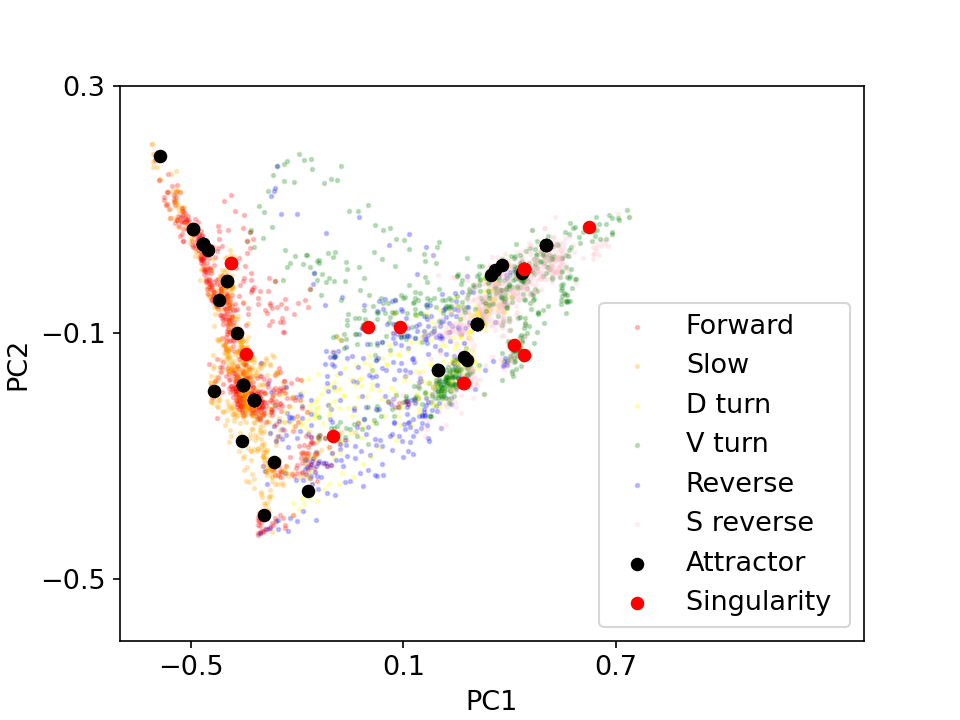

In [67]:
plt.figure(161)

state1=trst1=learnst(data0.to(dev),3000)
statelas1=state1[0];
lasswi=0
for k in range(3000):
    if state1[k+1]!=statelas1:
        labeler=statelas1.clone().type(torch.int).item()-1
        name="linel"+'%d' %labeler
        locals()[name]=plt.scatter(data0[lasswi:k+2,0],data0[lasswi:k+2,1],s=3,color=colorname[labeler],alpha=0.2)
#         plt.plot(data0[lasswi:k+2,0:1],data0[lasswi:k+2,1:2],color=colorname[statelas1.clone().type(torch.int).item()-1],alpha=0.3)
        lasswi=k+1
        statelas1=state1[k+1]




# for tt in range(100):
#     if stpoi[0,tt+1]==0:
#         break;

# print(tt)

stpoicp=stpoi.to(torch.device("cpu"))

for t in range(tt):
    mindis=100;colabel=0;
#     for i in range(7):
#         for j in range(leishu[i]):
#             if torch.dist(stpoi[:,t+1],stcogo[:,stcoar[j,i].clone().type(torch.int)-1,i])<mindis:
#                 mindis=torch.dist(stpoi[:,t+1],stcogo[:,stcoar[j,i].clone().type(torch.int)-1,i])
#                 colabel=i+1

#     print(stpoi[:,t+1],stcogo[:,stcoar[j,i].clone().type(torch.int)-1,i])

#     plt.scatter(stpoi[0,t+1].detach(),stpoi[1,t+1].detach(),s=30,color=colorname[colabel-1])
    if stpoitr2[t]<=3:
        linel9=plt.scatter(stpoicp[0,t+1].detach(),stpoicp[1,t+1].detach(),s=30,color="black")
    else:
        linel10=plt.scatter(stpoicp[0,t+1].detach(),stpoicp[1,t+1].detach(),s=30,color="red")

    
# linel9=plt.scatter(stpoi[0,1:tt].detach(),stpoi[1,1:tt].detach(),s=30,color="black")


plt.legend([linel0,linel1,linel2,linel3,linel4,linel6,linel9,linel10],["Forward","Slow","D turn","V turn","Reverse","S reverse","Attractor","Singularity "],fontsize=13)
plt.xlim([-0.7,1.4])
plt.ylim([-0.6,0.3])
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("PC1",fontsize=13)
plt.ylabel("PC2",fontsize=13)
ax=plt.gca()
ax.set_xticks([-0.5, 0.1, 0.7])
ax.set_yticks([-0.5, -0.1, 0.3])

# savefig_path="./lastout/out-ori/2c"
# plt.savefig(savefig_path+".pdf",dpi=500)
# plt.savefig(savefig_path+".tif",dpi=500)


# plt.title("the small points are data")
# plt.savefig("./pic/show5/21.png",dpi=500)

<IPython.core.display.Javascript object>


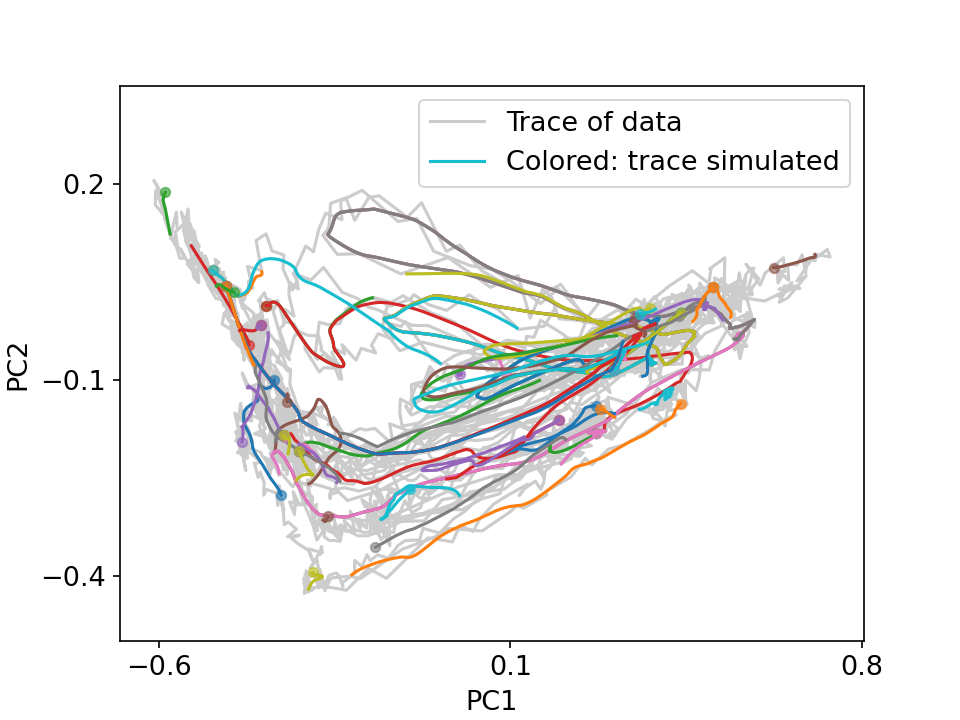

tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(1.164153218269348e-10)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(3.134578430152857e-10)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.000590187730268)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.000967190600932)
tensor(0.)
tensor(0.)
tensor(0.)


In [61]:
plt.figure(160)

line1,=plt.plot(data0[0:3000,0:1],data0[0:3000,1:2],color="gray",alpha=0.4)

plt.xlabel("PC1")
plt.ylabel("PC2")
ax=plt.gca()
ax.set_xticks([-0.6, 0.1, 0.8])
ax.set_yticks([-0.4, -0.1, 0.2])
plt.ylim(-0.5,0.35)
tempcount=0

for j in range(1):
    for i in range(60):
        name="xxa"+"s"+'%d' %j
        line2,=plt.plot(locals()["w1"+name+"cp"][0:12000,i,0].squeeze(-1),locals()["w1"+name+"cp"][0:12000,i,1].squeeze(-1))
        line2.set_zorder(1)
        line1.set_zorder(0)
        plt.scatter(locals()["w1"+name+"cp"][winr-1,i,0].detach(),locals()["w1"+name+"cp"][winr-1,i,1].detach(),s=20,alpha=0.6)
#         line2,=plt.plot(locals()["w1"+name][winl:winr,0:1].squeeze(-1),locals()["w1"+name][winl:winr,1:2].squeeze(-1))        
        
# plt.title("each color means a trace we simulated\n and the point means the end of the trace")
# plt.legend([line1,line2],["trace of data","and others: trace simulated"])
        plt.legend([line1,line2],["Trace of data","Colored: trace simulated"],fontsize=13)
        print(torch.dist(locals()["w1"+name+"cp"][10000,i],locals()["w1"+name+"cp"][11000,i]))
        if torch.dist(locals()["w1"+name+"cp"][10000,i],locals()["w1"+name+"cp"][11000,i])<1e-2:
            tempcount=tempcount+1

tempcount

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("PC1",fontsize=13)
plt.ylabel("PC2",fontsize=13)
# savefig_path="./lastout/out-ori/2b"
# plt.savefig(savefig_path+".pdf",dpi=500)
# plt.savefig(savefig_path+".tif",dpi=500)



# plt.savefig("./pic/show4/2.png",dpi=500)

In [38]:
#测试用
# test1=data0
# print(test1)
# test1=test1@traa+cc0
# print(test1)

In [69]:
#储存轨迹

#6:19,7:10,8:5,0:15-19

# for j in range(1):
#     for i in range(15):
# #         if i<15:
# #             continue
#         name="xxa"+"s"+'%d' %j
#         torch.save(locals()["w1"+name+"cp"],"./tr/rewrite/1/tr"+'%d' %i+".pth")


# j=2
# name="xxa"+"s"+'%d' %j
# torch.save(locals()["w1"+name+"cp"],"./tr/cyc2/1/tr_see=1nice_simnu=15.pth")


# name="xxa"+"s"+'%d' %j
# torch.save(locals()["w1"+name+"cp"],"./lastout/2-trace/tr_see=567nice_simnu=60.pth")

# name="xxa"+"s"+'%d' %j
# torch.save(locals()["w1"+name+"cp"],"./lastout/3-trace/trnonoise_simnu=60.pth")

# name="xxa"+"s"+'%d' %j
# torch.save(locals()["w1"+name+"cp"],"./lastout/3-trace/trbignoise_see=0_simnu=60.pth")

# name="xxa"+"s"+'%d' %j
# torch.save(locals()["w1"+name+"cp"],"./lastout/8-ban13/trban13_see=3and5_simnu=16.pth")

# torch.save(locals()["w1"+name+"cp"],"./tr/rewrite/1/tr.pth")

# torch.save(stpoitr2,"./poi/poitr22"+".pth")

In [25]:
# torch.save(model,"./mod/re/3/modqig_seg2st1ss2niceseetrace15161718.pth") #储存模型
# torch.save(model2,"./mod/modelstate2.pth") #储存模型

In [13]:
torch.cuda.empty_cache()